In [3]:
install.packages("naivebayes")

package 'naivebayes' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\David\AppData\Local\Temp\Rtmp2Xudny\downloaded_packages


In [4]:
library(naivebayes)

Warning message:
"package 'naivebayes' was built under R version 3.6.3"naivebayes 0.9.7 loaded


In [6]:
install.packages("kernlab")
library(kernlab)

package 'kernlab' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\David\AppData\Local\Temp\Rtmp2Xudny\downloaded_packages



Attaching package: 'kernlab'

The following object is masked from 'package:purrr':

    cross

The following object is masked from 'package:ggplot2':

    alpha



In [8]:
library(dslabs)
library(caret)
mnist <- read_mnist()

# it consists of predefined train and test sets
names(mnist)

# each components includes a matrix with features in columns
dim(mnist$train$images)

# it includes a vector with the classes as integers
class(mnist$train$labels)
table(mnist$train$labels)

# as we want this to run on low powered machines in under an hour, we take a subset
set.seed(123, sample.kind = "Rounding")
index <- sample(nrow(mnist$train$images), 10000)
x <- mnist$train$images[index,]
y <- factor(mnist$train$labels[index])

index <- sample(nrow(mnist$train$images), 1000)
x_test <- mnist$train$images[index,]
y_test <- factor(mnist$train$labels[index])

[1] "train" "test"

[1] 60000   784

[1] "integer"


   0    1    2    3    4    5    6    7    8    9 
5923 6742 5958 6131 5842 5421 5918 6265 5851 5949 

Warning message in set.seed(123, sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"

Warning message:
"package 'matrixStats' was built under R version 3.6.3"
Attaching package: 'matrixStats'

The following object is masked from 'package:dplyr':

    count



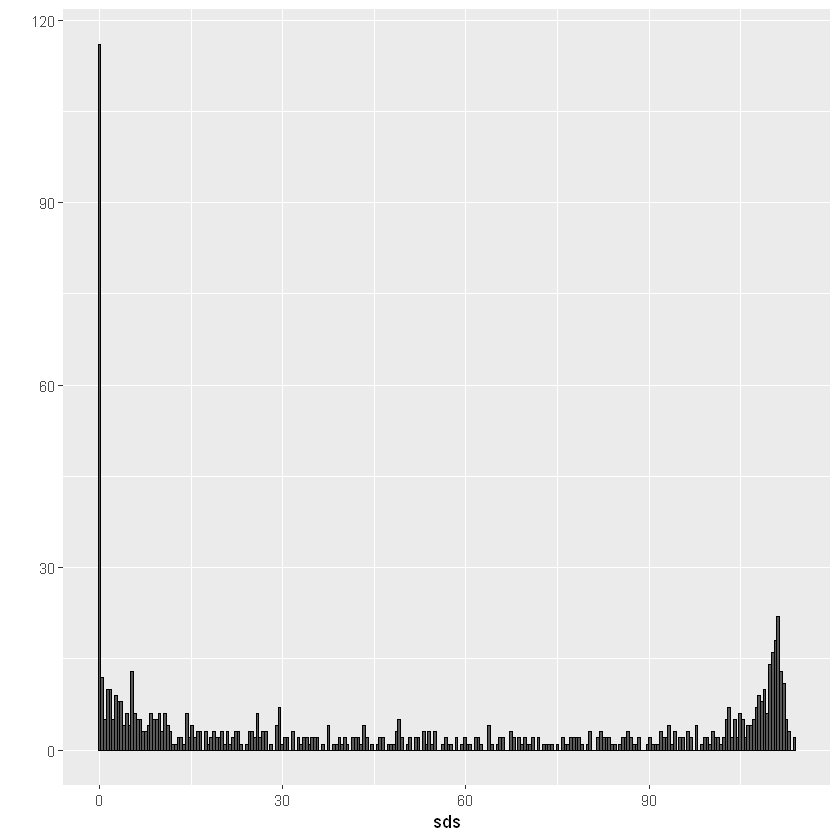

[1] 252

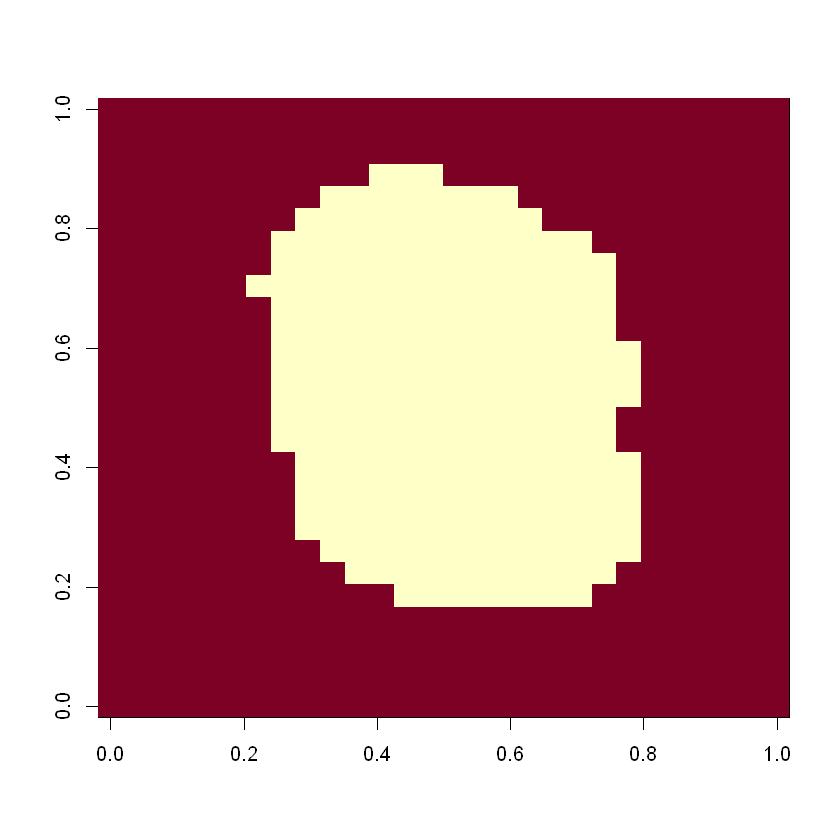

In [9]:
# config
# run 6-1-1
library(matrixStats)

# we can compute the SD of each column and plot them on a histogram
sds <- colSds(x)
qplot(sds, bins = 256, color = I("black"))

# the caret package includes a function that recommends features to be removed due to near 0 variance
nzv <- nearZeroVar(x)
    # we can plot it as an image, the maroon are columns that are to be removed
    image(matrix(1:784 %in% nzv, 28, 28))

# we can see how many remaining columns there are after removing the low variate predictors
col_index <- setdiff(1:ncol(x), nzv)
length(col_index)

In [1]:
# config
# run 6-1-1 & 6-1-2

# caret package requires column names to the feature matrices
colnames(x) <- 1:ncol(mnist$train$images)
colnames(x_test) <- colnames(mnist$train$images)

# we will start with kNN
    # first step is to optimise the number of neighbours
    control <- trainControl(method = "cv", number = 10, p = 0.9)
    train_knn <- train(x[, col_index], y,
                       method = "knn",
                       tuneGrid = data.frame(k=c(1,3,5,7)),
                       trControl = control)
    
        # this code takes several minutes to complete,
        # it is good practice to test on subsets of code
        # to appreciate the time it will take
        n <- 1000 # number of rows to test
        b <- 2 # number of cross-validation folds
        index <- sample(nrow(x), n)
        control <- trainControl(method = "cv", number = b, p = 0.9)
        train_knn <- train(x[index,col_index], y[index],
                           method = "knn",
                           tuneGrid = data.frame(k=c(1,3,5,7)),
                           trControl = control)
        ggplot(train_knn)
        
    # once we're done optimising, we can fit the entire dataset
    fit_knn <- knn3(x[ ,col_index], y, k=3)
        
    # and we can evaluate the model
    y_hat_knn <- predict(fit_knn,
                         x_test[, col_index],
                         type="class")
    
    cm <- confusionMatrix(y_hat_knn, factor(y_test))   
    
    cm$overall["Accuracy"]  
    cm$byClass[,1:2]

# Random Forest, rborist package for performance advantage
    # as random forest is more computationally taxing we start by using a subset
    # even with the subset it will take a few minutes to run
    library(Rborist)
    control <- trainControl(method="cv", number = 5, p = 0.5)    
    grid <- expand.grid(minNode = c(1,5), predFixed = c(10, 15, 25, 35, 50))    
    
    train_rf <- train(x[,col_index],
                      y,
                      method = "Rborist",
                      nTree = 50,
                      trControl = control,
                      tuneGrid = grid,
                      nSamp = 5000)    
    
    # we can see the final result by plotting the model
    ggplot(train_rf, highlight = TRUE)
    
    # we can select the best parameters best on the bestTune
    train_rf$bestTune
    
    # now we can optimise our final tree
    # this will also take a few minutes
    fit_rf <- Rborist(x[, col_index], y,
                      nTree = 1000,
                      minNode = train_rf$bestTune$minNode,
                      predFixed = train_rf$bestTune$predFixed)
    
    # and we can evaluate the model
    y_hat_rf <- factor(levels(y)[predict(fit_rf, x_test[,col_index])$yPred])
    cm <- confusionMatrix(y_hat_rf, y_test)
    
    cm$overall["Accuracy"]    
    cm$byClass[,1:2]
    
# we can now see the image and our prediction
library(rafalib)
rafalib::mypar(3,4)
for(i in 1:12){
  image(matrix(x_test[i,], 28, 28)[, 28:1],
        main = paste("Our prediction:", y_hat_rf[i]),
        xaxt = "n", yaxt = "n")
}

ERROR: Error in ncol(mnist$train$images): object 'mnist' not found


In [2]:
# config
# run 6-1-1

# Rborist doesnt include variable importance calculations
# we will use rf and not pre-process to show the variable importance concept
library(randomForest)
x <- mnist$train$images[index,]
y <- factor(mnist$train$labels[index])
rf <- randomForest(x, y, ntree = 50)

# we can use the importance() function, which gives us further interpretability
imp <- importance(rf)
imp

# we can then make an image using the importance values, giving us a heatmap
image(matrix(imp, 28,28))

# visualisation is important in discerning why we're failing, and is different per application
# for the digits, we find digits we were quite certain of but were incorrect
    # first we compare kNN
    p_max <- predict(fit_knn, x_test[,col_index])
    p_max <- apply(p_max, 1, max)
    ind <- which(y_hat_knn != y_test)
    ind <- ind[order(p_max[ind], decreasing = TRUE)]
    rafalib::mypar(3,4)
    for(i in ind[1:12]){
      image(matrix(x_test[i,], 28, 28)[,28:1],
            main = paste0("Pr(",y_hat_knn[i],")=",round(p_max[i], 2),
                          " but is a ",y_test[i]),
            xact="n", yaxt="n")
    }

    # then we compare rf
    p_max <- predict(fit_rf, x_test[,col_index])$census 
    p_max <- p_max / rowSums(p_max)
    p_max <- apply(p_max, 1, max)
    ind  <- which(y_hat_rf != y_test)
    ind <- ind[order(p_max[ind], decreasing = TRUE)]
    for(i in ind[1:12]){
      image(matrix(x_test[i,], 28, 28)[, 28:1], 
            main = paste0("Pr(",y_hat_rf[i],")=",round(p_max[i], 2),
                          " but is a ",y_test[i]),
            xact="n", yact="n")
    }

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


ERROR: Error in eval(expr, envir, enclos): object 'mnist' not found


In [3]:
# config
# run 6-1-1
library(tidyverse)
library(caret)
library(dslabs)

# this will also take a few minutes
fit_rf <- Rborist(x[, col_index], y,
                  nTree = 1000,
                  minNode = train_rf$bestTune$minNode,
                  predFixed = train_rf$bestTune$predFixed)

fit_knn <- knn3(x[,col_index], y, k=3)

# ensembling is combining the results of different algorithms
# computing new class probabilities by taking the average of the class probabilities
p_rf <- predict(fit_rf, x_test[,col_index])$census
p_rf <- p_rf / rowSums(p_rf)
p_knn <- predict(fit_knn, x_test[,col_index])
p <- (p_rf + p_knn)/2
y_pred <- factor(apply(p, 1, which.max)-1)
confusionMatrix(y_pred, y_test)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.1     v purrr   0.3.4
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::combine()  masks randomForest::combine()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks stats::lag()
x ggplot2::margin() masks randomForest::margin()
Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr

ERROR: Error in Rborist(x[, col_index], y, nTree = 1000, minNode = train_rf$bestTune$minNode, : could not find function "Rborist"


In [14]:
install.packages("fastAdaboost")

package 'fastAdaboost' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\David\AppData\Local\Temp\Rtmp8iJg6Y\downloaded_packages


In [5]:
library(fastAdaboost)

In [6]:
# config
library(tidyverse)
library(caret)
library(dslabs)

set.seed(1, sample.kind = "Rounding")
data("mnist_27")

models <- c("glm", "lda", "naive_bayes", "svmLinear", "knn", "gamLoess", "multinom", "qda", "rf", "adaboost")

# train the mnist model with the 10 models
fits <- lapply(models, function(model){
  print(model)
  train(y~., method = model, data = mnist_27$train)
})

names(fits) <- models

# Q2 - create a matrix of predictions, the matrix should be 200 rows and 10 columns
pred <- sapply(fits, function(object) 
  predict(object, newdata = mnist_27$test))
dim(pred)
pred

# Q3 - report the mean accuracy across all models
glm_acc <- sum(ifelse(pred[,1]==mnist_27$test$y, 1, 0))/200 # glm
lda_acc <-sum(ifelse(pred[,2]==mnist_27$test$y, 1, 0))/200 # lda
nb_acc <-sum(ifelse(pred[,3]==mnist_27$test$y, 1, 0))/200 # naive_bayes
sl_acc <-sum(ifelse(pred[,4]==mnist_27$test$y, 1, 0))/200 # svmLinear
knn_acc <-sum(ifelse(pred[,5]==mnist_27$test$y, 1, 0))/200 # knn
gam_acc <-sum(ifelse(pred[,6]==mnist_27$test$y, 1, 0))/200 # gamLoess
mul_acc <-sum(ifelse(pred[,7]==mnist_27$test$y, 1, 0))/200 # multinom
qda_acc <-sum(ifelse(pred[,8]==mnist_27$test$y, 1, 0))/200 # qda
rf_acc <-sum(ifelse(pred[,9]==mnist_27$test$y, 1, 0))/200 # rf
ada_acc <-sum(ifelse(pred[,10]==mnist_27$test$y, 1, 0))/200 # adaboost
sum(glm_acc, lda_acc, nb_acc, sl_acc, knn_acc, gam_acc, mul_acc, qda_acc, rf_acc, ada_acc)/10
    #EDX CORRECT ANSWER
    acc <- colMeans(pred == mnist_27$test$y)
    acc
    mean(acc)

# Q4 - build an ensemble prediction by majority vote, compute the accuracy
row_acc <- rowMeans(pred == 2)
p_mod <- ifelse(row_acc > 0.5, 2,7)
y_hat <- confusionMatrix(factor(p_mod), mnist_27$test$y)$overall["Accuracy"]
y_hat


Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.1     v purrr   0.3.4
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Warning message:
"package 'dslabs' was built under R version 3.6.3"Warning message in set

[1] "glm"
[1] "lda"
[1] "naive_bayes"
[1] "svmLinear"
[1] "knn"
[1] "gamLoess"


Loading required package: gam
Warning message:
"package 'gam' was built under R version 3.6.3"Loading required package: splines
Loading required package: foreach

Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Loaded gam 1.16.1

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"Warning message in gam.lo(data[["lo(x_1, span = 0.5, degree = 1)"]], z, w, span = 0.5, :
"eval  0.46667"Warning message in gam.lo(data[["lo(x_1, span = 0.5, degree = 1)"]], z, w, span = 0.5, :
"upperlimit  0.41586"Warning message in gam.lo(data[["lo(x_1, span = 0.5, degree = 1)"]], z, w, span = 0.5, :
"extrapolation not allowed with blending"Warning message in gam.lo(data[["lo(x_1, span = 0.5, degree = 1)"]], z, w, span = 0.5, :
"eval  0.4375"Warning message in gam.lo(data[["lo(x_1, span = 0.5, degree = 1)"]], z, w, span = 0.5, :
"upperlimit  0.41586"Warning message in gam.lo(data[["lo(x_1, span = 0.5, deg

[1] "multinom"
# weights:  4 (3 variable)
initial  value 554.517744 
iter  10 value 384.794809
final  value 384.794775 
converged
# weights:  4 (3 variable)
initial  value 554.517744 
final  value 421.251454 
converged
# weights:  4 (3 variable)
initial  value 554.517744 
iter  10 value 384.848555
final  value 384.848522 
converged
# weights:  4 (3 variable)
initial  value 554.517744 
iter  10 value 358.466023
final  value 358.466014 
converged
# weights:  4 (3 variable)
initial  value 554.517744 
final  value 400.257332 
converged
# weights:  4 (3 variable)
initial  value 554.517744 
iter  10 value 358.528966
final  value 358.528958 
converged
# weights:  4 (3 variable)
initial  value 554.517744 
iter  10 value 345.361326
final  value 345.361319 
converged
# weights:  4 (3 variable)
initial  value 554.517744 
final  value 389.162400 
converged
# weights:  4 (3 variable)
initial  value 554.517744 
iter  10 value 345.427631
final  value 345.427624 
converged
# weights:  4 (3 variable)
i

[1] 200  10

glm,lda,naive_bayes,svmLinear,knn,gamLoess,multinom,qda,rf,adaboost
2,2,2,2,2,2,2,2,2,2
7,7,7,7,7,7,7,7,7,7
7,7,7,7,7,7,7,7,7,7
7,7,7,7,7,7,7,7,7,7
7,7,7,7,7,7,7,7,7,7
2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2
7,7,2,7,2,2,7,2,2,2
7,7,7,7,7,7,7,7,7,7


[1] 0.787

glm         lda naive_bayes   svmLinear         knn    gamLoess 
      0.750       0.750       0.795       0.755       0.840       0.845 
   multinom         qda          rf    adaboost 
      0.750       0.820       0.780       0.785

[1] 0.787

Accuracy 
    0.81

In [7]:
# Q5 - which individual methods perform better than the ensemble
ind <- acc > mean(p_mod == mnist_27$test$y)
sum(ind)
models[ind]

# Q6 - obtain the minimum accuracy estimates, report the mean
reAcc <- sapply(fits, function(object){
  mean(object[["resample"]][["Accuracy"]])
})
mean(reAcc)
    #EDX CORRECT ANSWER
    acc_hat <- sapply(fits, function(fit) min(fit$results$Accuracy))
    mean(acc_hat)

[1] 3

[1] "knn"      "gamLoess" "qda"

[1] 0.8126215

[1] 0.8085677

In [8]:
# Q7 - only use methods with an estimated accuracy of > 0.8
ind <- reAcc >= 0.8
mean(reAcc[ind])
    #EDX CORRECT ANSWER
    ind <- reAcc >= 0.8
    votes <- rowMeans(pred[,ind] == "7")
    y_hat <- ifelse(votes>=0.5, 7, 2)
    mean(y_hat == mnist_27$test$y)

[1] 0.8198998

[1] 0.835

In [9]:
library(tidyverse)
library(caret)
library(dslabs)
data("tissue_gene_expression")
dim(tissue_gene_expression$x)

[1] 189 500

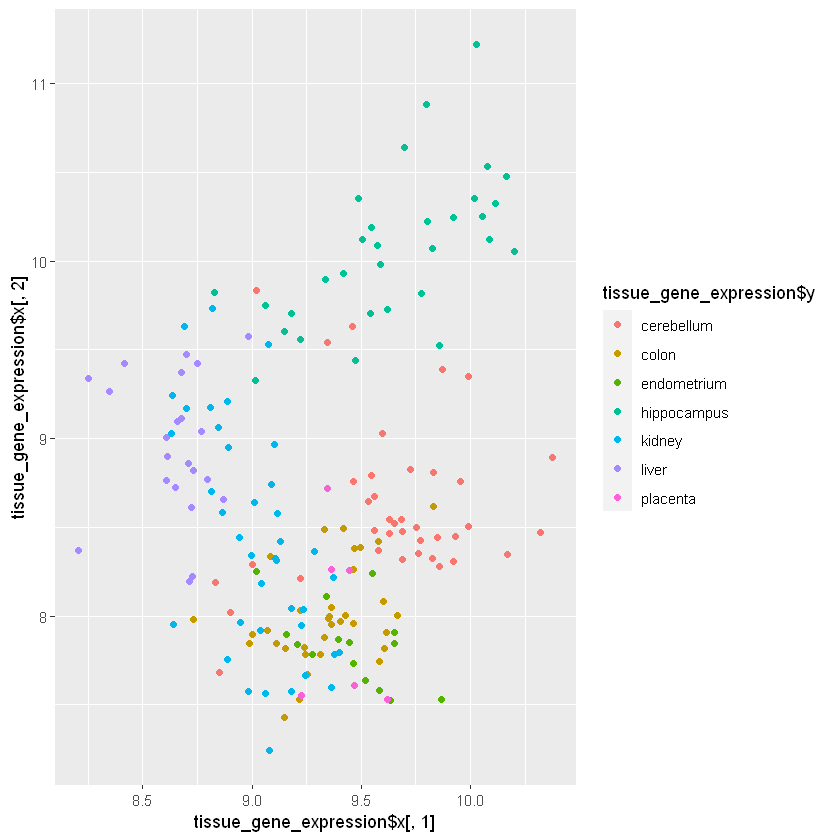

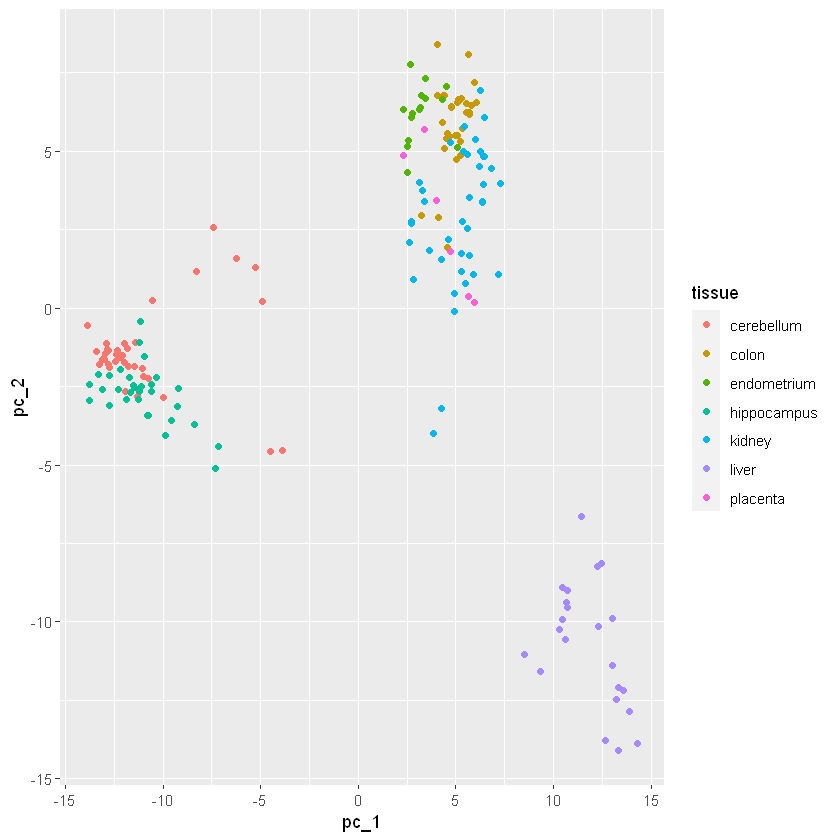

In [10]:
# Q1 - plot the first two components with color, which tissue is a cluster?
qplot(tissue_gene_expression$x[,1], tissue_gene_expression$x[,2],
      col=tissue_gene_expression$y)
    #EDX CORRECT ANSWER
    pc <- prcomp(tissue_gene_expression$x)
    data.frame(pc_1 = pc$x[,1], pc_2 = pc$x[,2], 
               tissue = tissue_gene_expression$y) %>%
      ggplot(aes(pc_1, pc_2, color = tissue)) +
      geom_point()

[1] 0.5969088

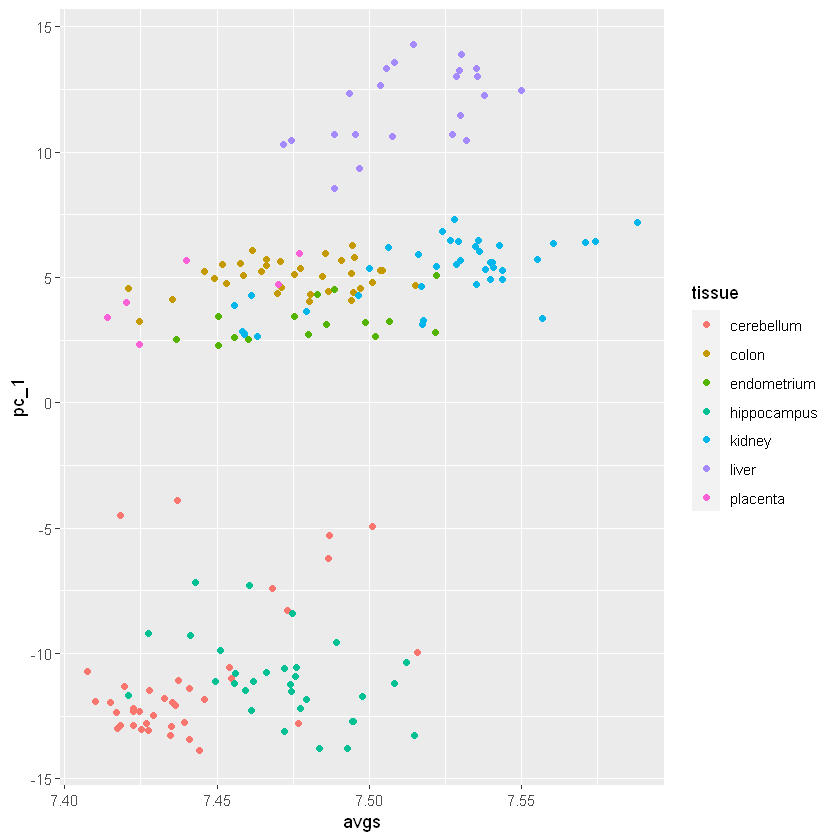

In [11]:
# Q2 - compute the average across all predictors, plot again the first PC
avgs <- rowMeans(tissue_gene_expression$x)
data.frame(pc_1 = pc$x[,1], avg = avgs, 
           tissue = tissue_gene_expression$y) %>%
  ggplot(aes(avgs, pc_1, color = tissue)) +
  geom_point()
cor(avgs, pc$x[,1])

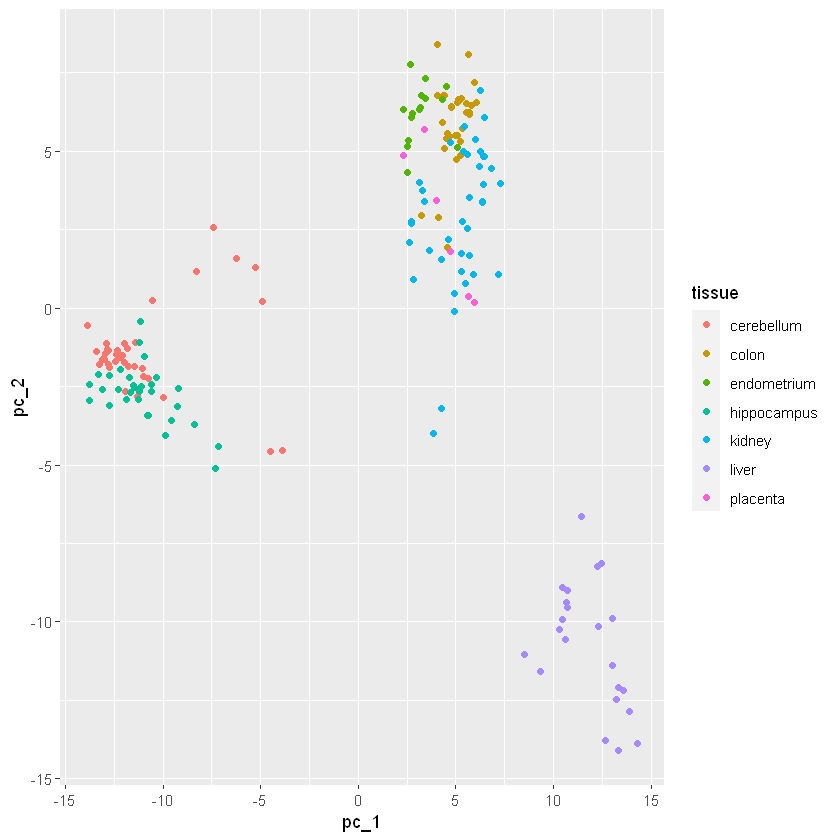

In [12]:
# Q3 - redo the PCA only after removing the centre
x <- with(tissue_gene_expression, sweep(x, 1, mean(x)))
pc <- prcomp(x)
data.frame(pc_1 = pc$x[,1], pc_2 = pc$x[,2], 
           tissue = tissue_gene_expression$y) %>%
  ggplot(aes(pc_1, pc_2, color = tissue)) +
  geom_point()

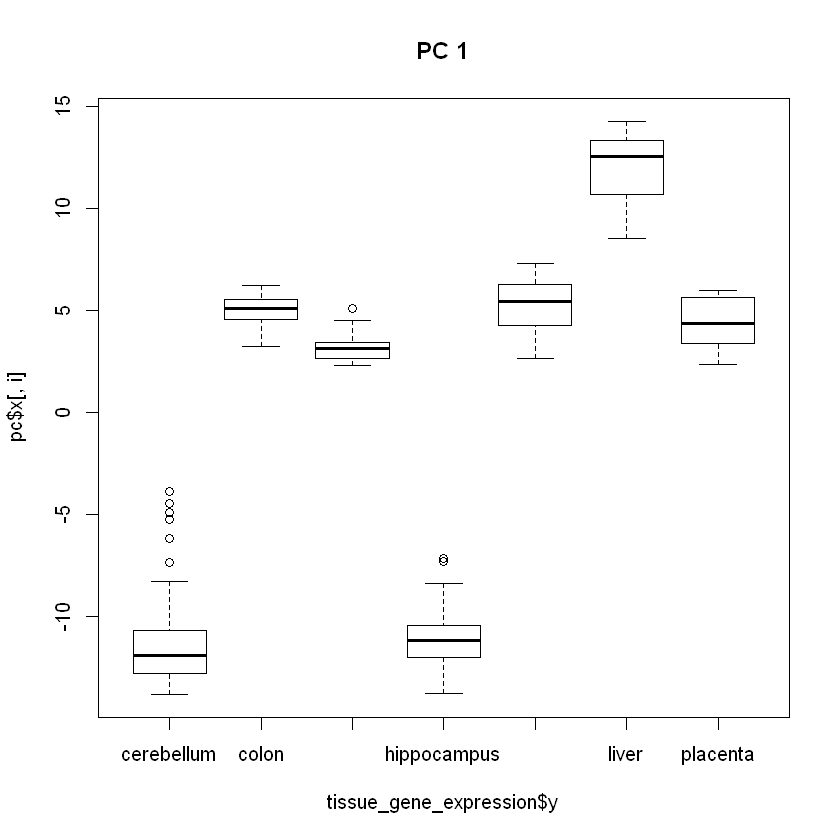

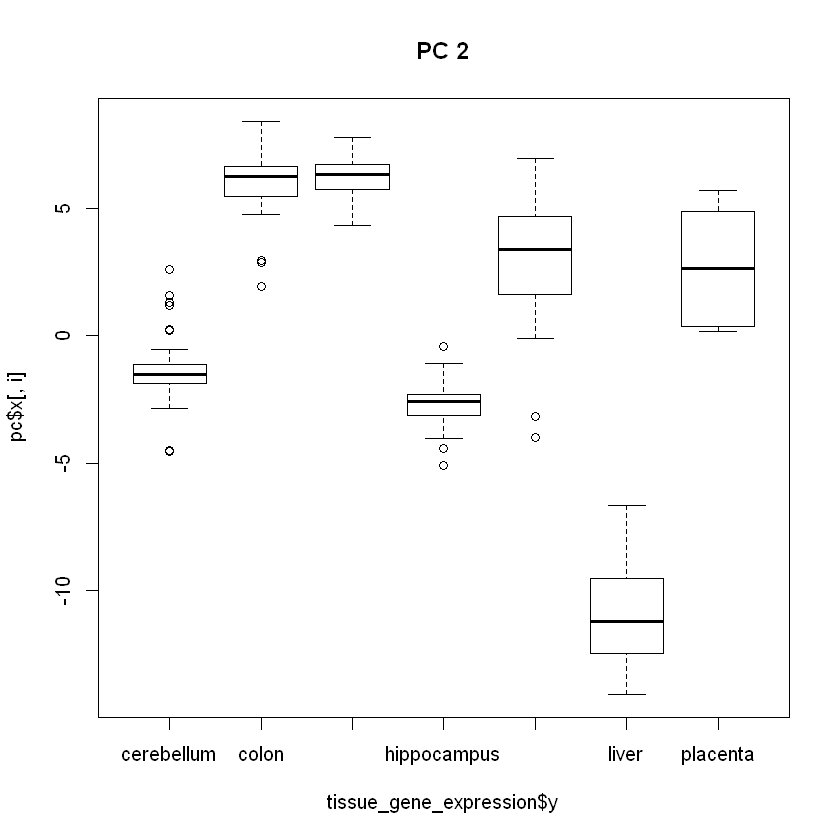

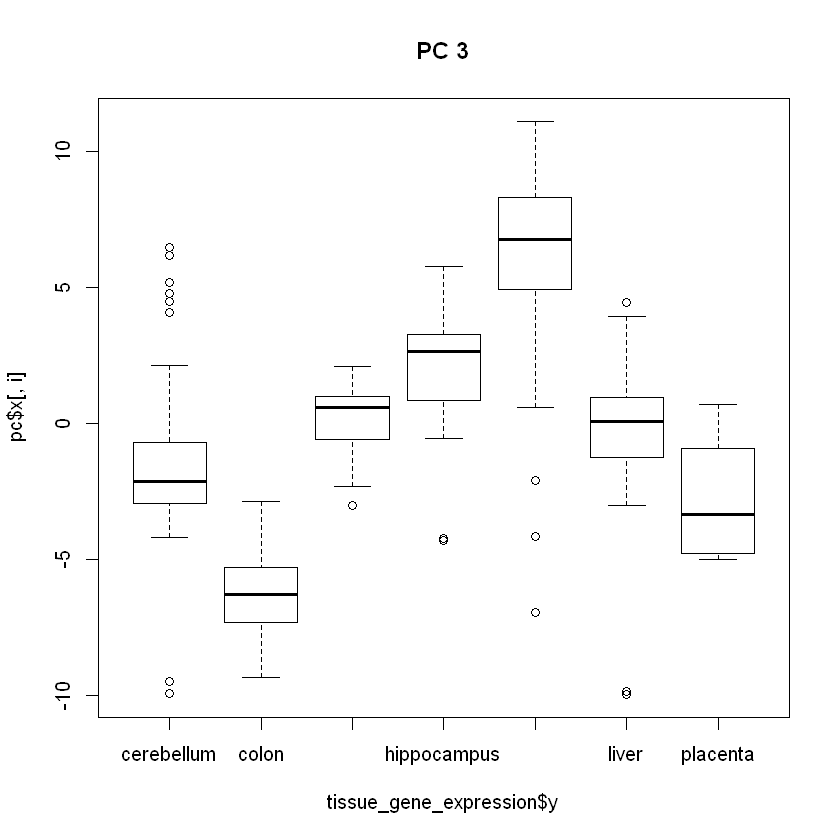

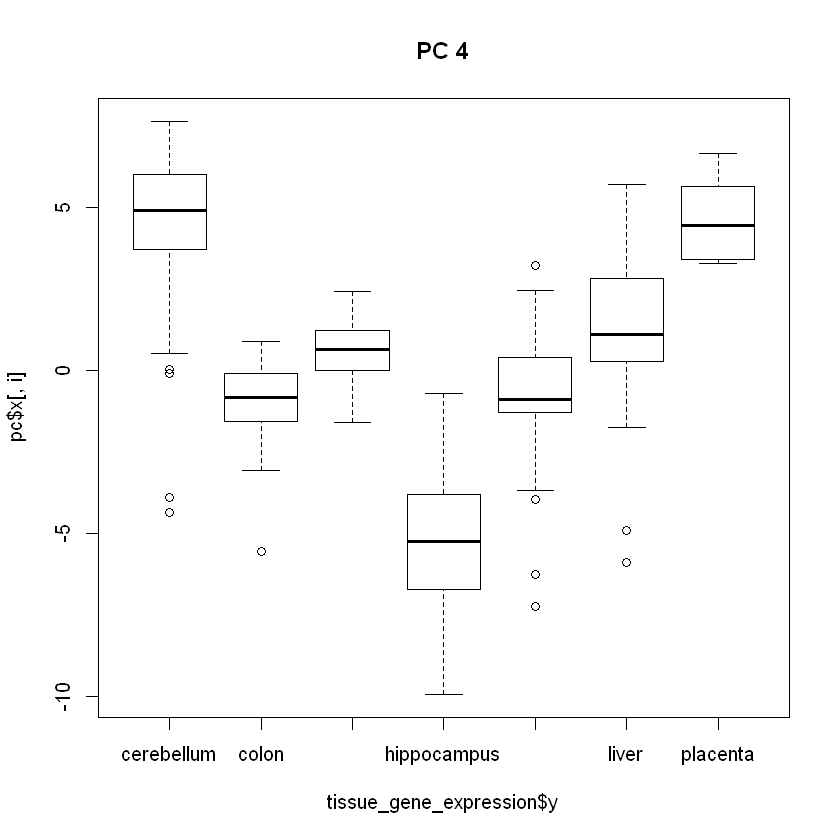

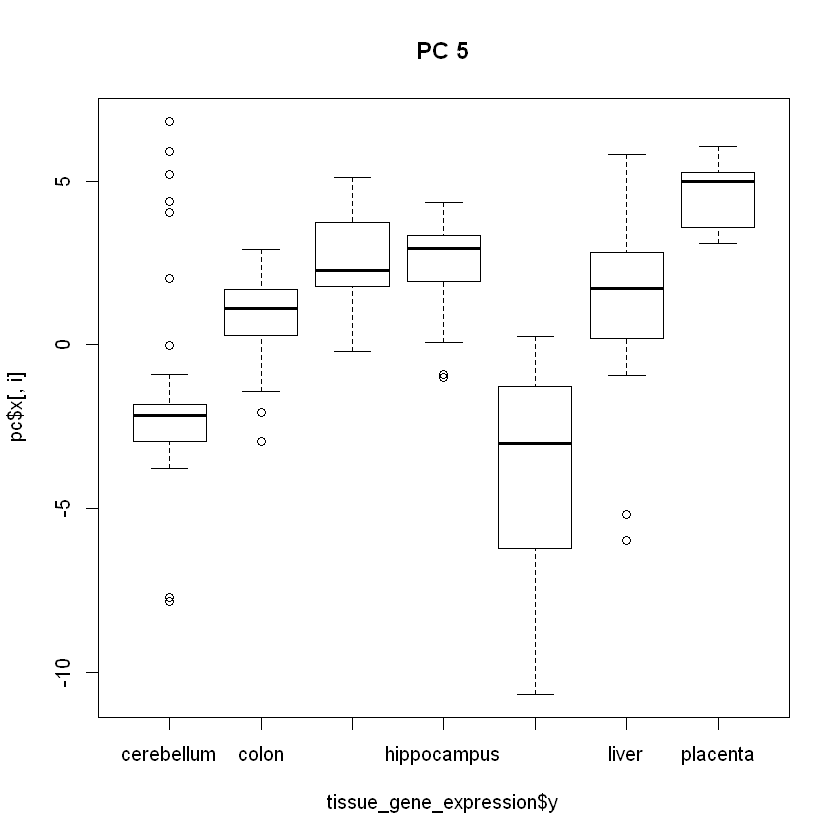

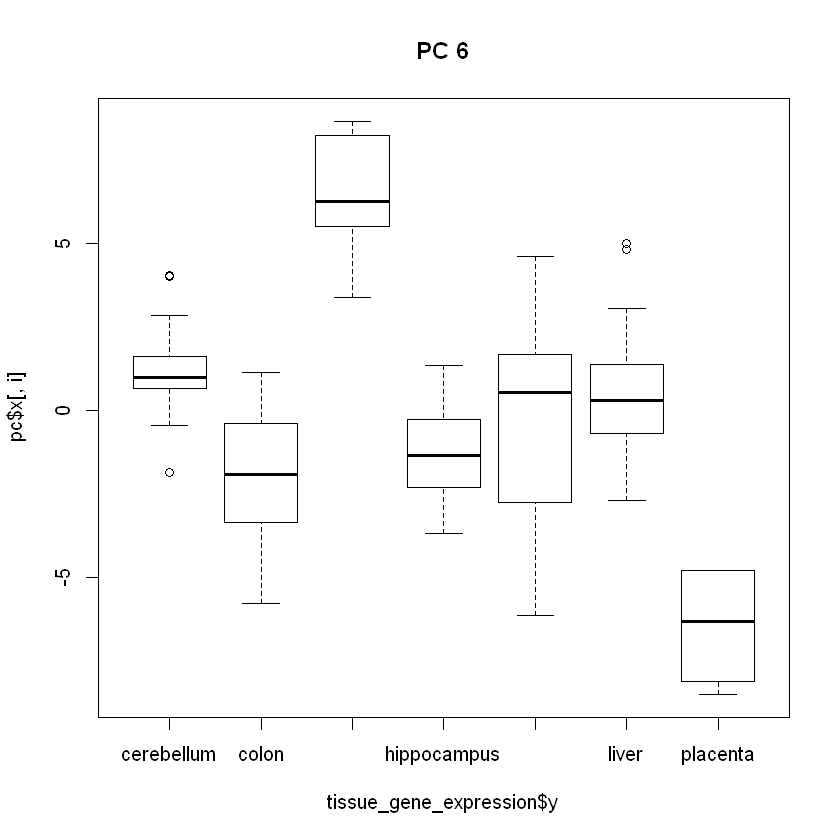

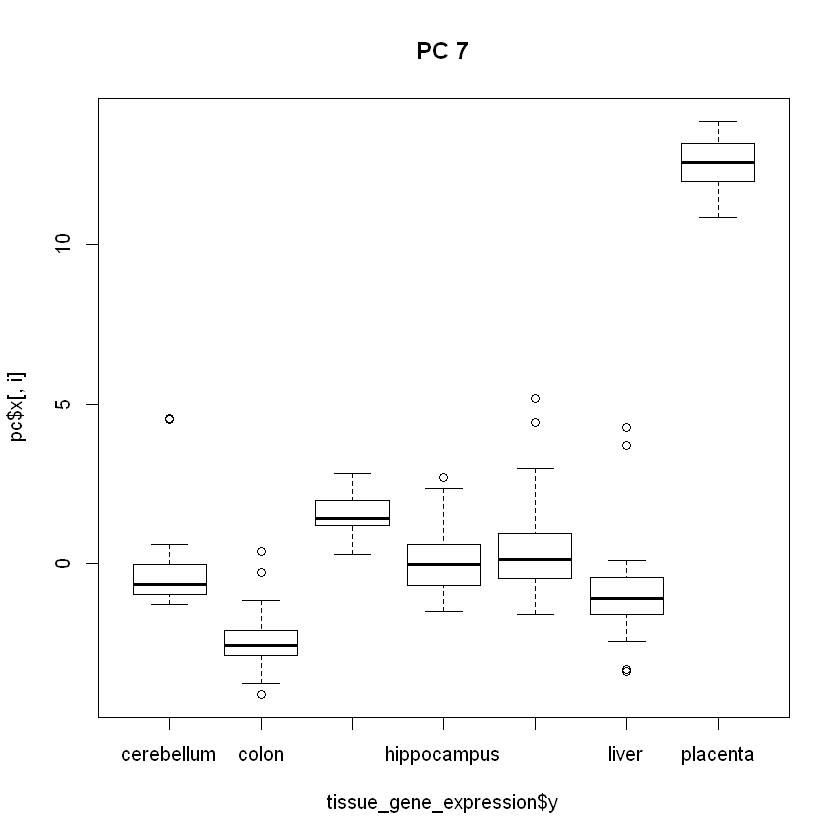

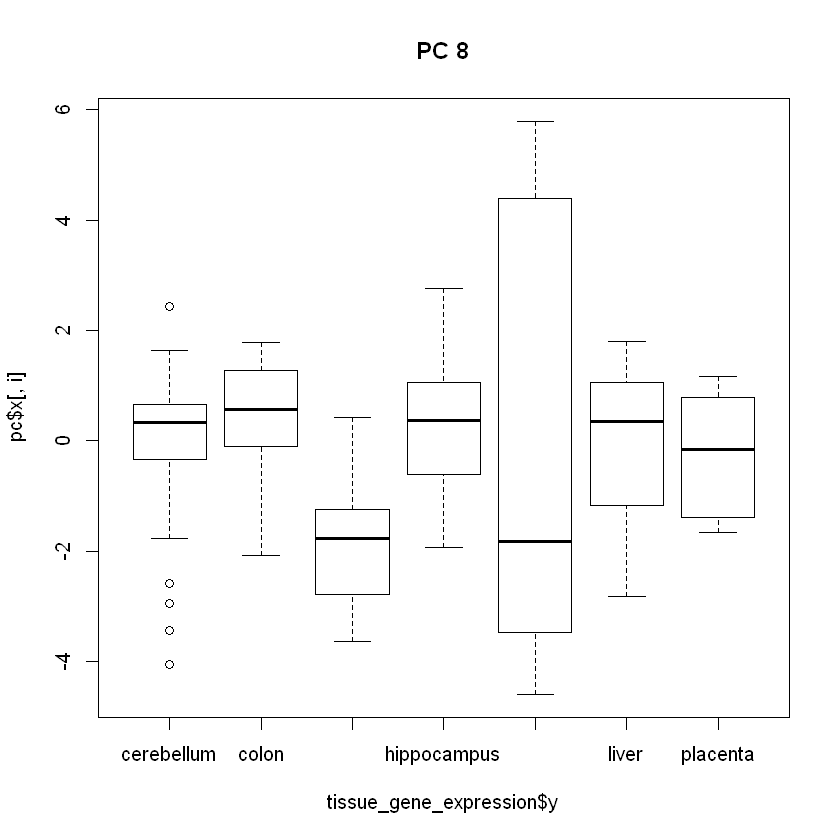

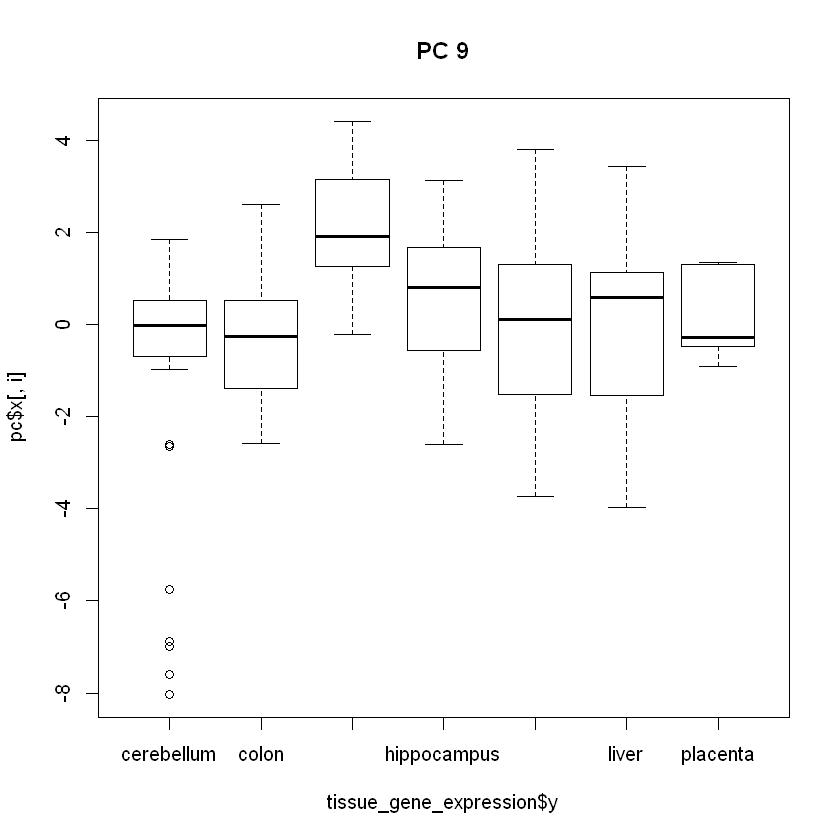

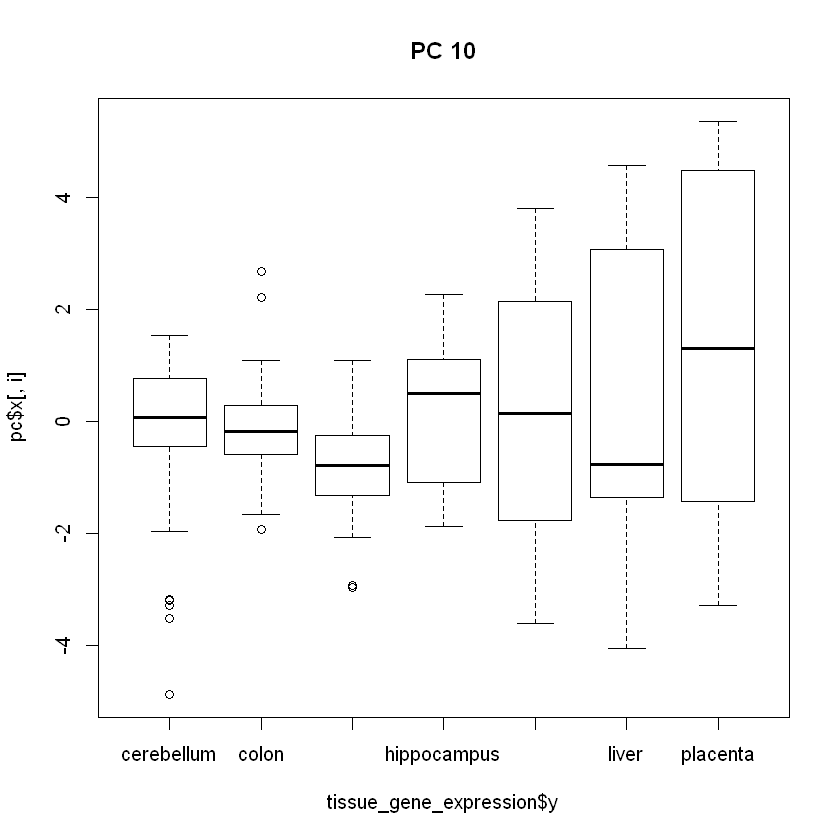

In [13]:
# Q4 - make a boxplot of the first 10 pcs, for the 7th which two tissues have the greatest median differences
for(i in 1:10){
  boxplot(pc$x[,i] ~ tissue_gene_expression$y, main = paste("PC", i))
}

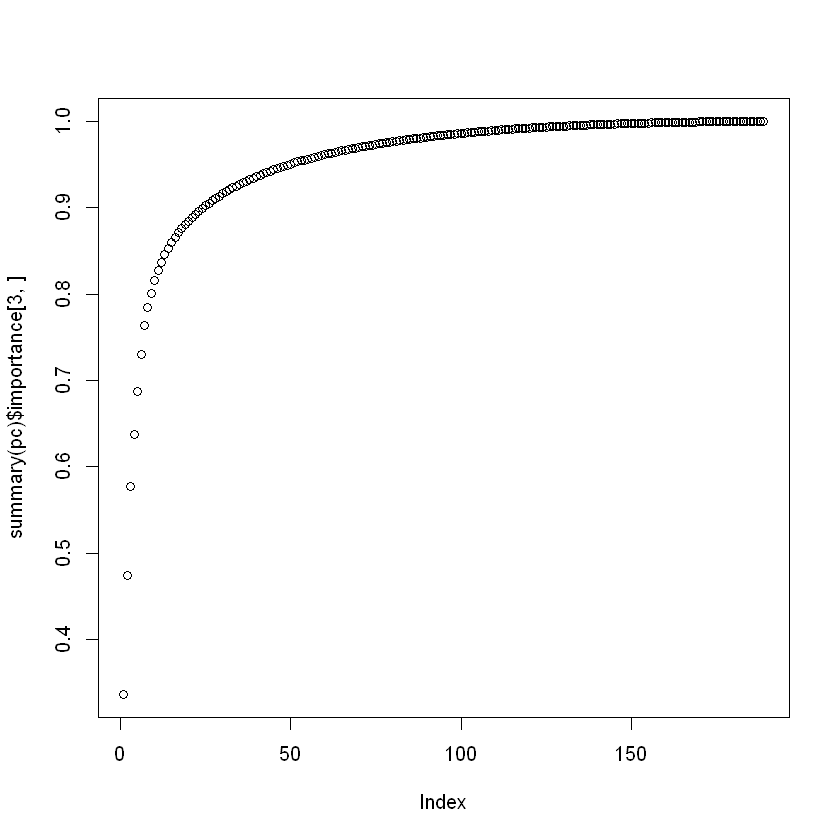

In [14]:
# Q5 - plot the percent variance by PC number
plot(summary(pc)$importance[3,])

In [15]:
# config
library(tidyverse)
library(lubridate)
library(dslabs)


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



Warning message:
"Removed 1 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_label)."

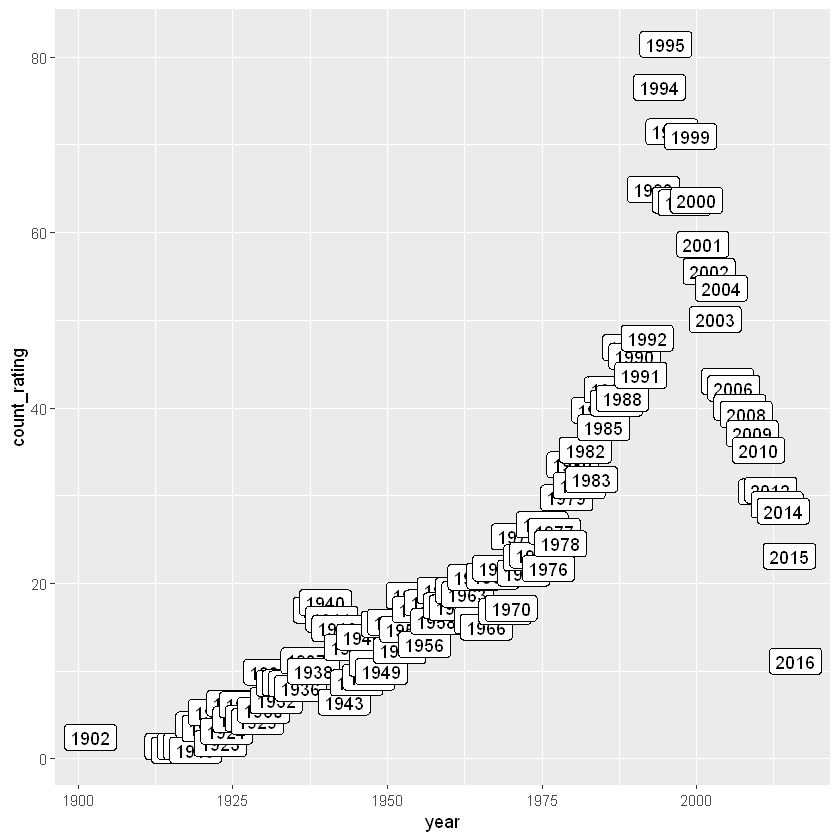

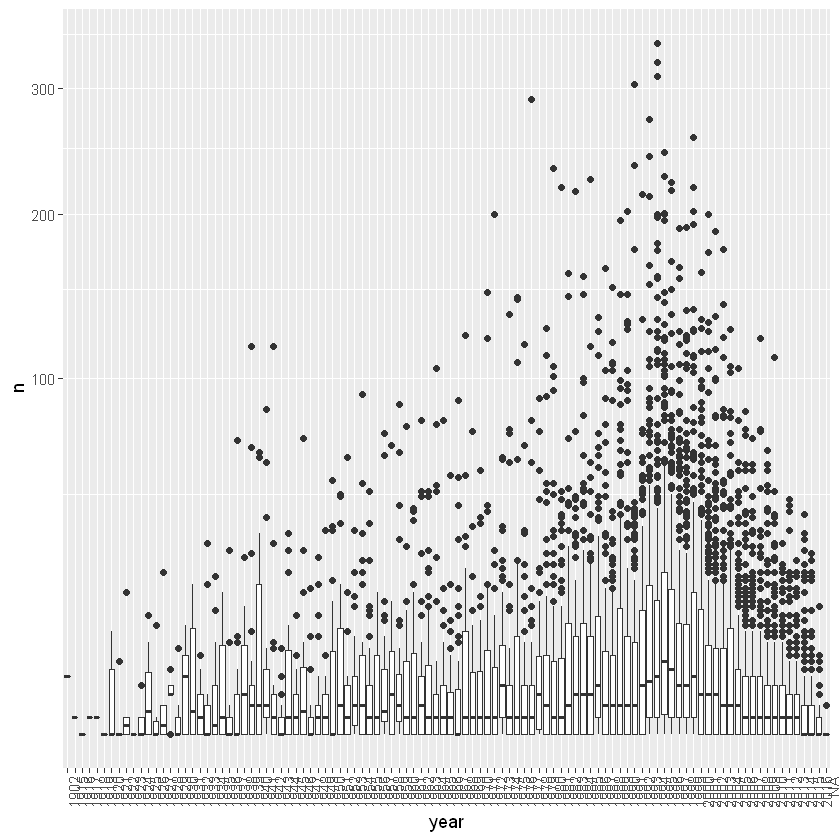

In [16]:
# Q1 - compute the number of ratings for each movie, plot it against the year
      # use the square root transformation, which year has the highest median
movielens %>%
  group_by(year) %>%
  summarize(count_rating = sqrt(n())) %>%
  ggplot(aes(year, count_rating, label = year)) +
  geom_point() +
  geom_label()

    # EDX CORRECT ANSWER
    movielens %>% group_by(movieId) %>%
      summarize(n = n(), year = as.character(first(year))) %>%
      qplot(year, n, data = ., geom = "boxplot") +
      coord_trans(y = "sqrt") +
      theme(axis.text.x = element_text(angle = 90, hjust = 1))


In [17]:
# Q2 - select the top 25 rated movies (n/year) from 1993 to 2018, what is the avg of shawshank
movielens %>%
  group_by(title) %>%
  filter(year >= 1993, year <= 2018) %>%
  summarize(n = n(), year = as.character(first(year)))

movielens %>%
  filter(title == "Shawshank Redemption, The") %>%
  group_by(year) %>%
  summarize(avg_rating = mean(rating))

movielens %>%
  group_by(year) %>%
  filter(title == "Forrest Gump") %>%
  summarize(n = n()/24)

    # EDX CORRECT ANSWER
    movielens %>% 
      filter(year >= 1993) %>%
      group_by(movieId) %>%
      summarize(n = n(), years = 2018 - first(year),
                title = title[1],
                rating = mean(rating)) %>%
      mutate(rate = n/years) %>%
      top_n(25, rate) %>%
      arrange(desc(rate))


title,n,year
'Hellboy': The Seeds of Creation,1,2004
'Salem's Lot,1,2004
'Til There Was You,4,1997
"""Great Performances"" Cats",2,1998
$9.99,3,2008
(500) Days of Summer,45,2009
...And God Spoke,1,1993
[REC],3,2007
1-900 (06),1,1994
10 Attitudes,1,2001


year,avg_rating
1994,4.487138


year,n
1994,14.20833


movieId,n,years,title,rating,rate
356,341,24,Forrest Gump,4.054252,14.208333
79132,111,8,Inception,4.049550,13.875000
2571,259,19,"Matrix, The",4.183398,13.631579
296,324,24,Pulp Fiction,4.256173,13.500000
318,311,24,"Shawshank Redemption, The",4.487138,12.958333
58559,121,10,"Dark Knight, The",4.235537,12.100000
4993,200,17,"Lord of the Rings: The Fellowship of the Ring, The",4.182500,11.764706
5952,188,16,"Lord of the Rings: The Two Towers, The",4.061170,11.750000
7153,176,15,"Lord of the Rings: The Return of the King, The",4.127841,11.733333
2858,220,19,American Beauty,4.236364,11.578947


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


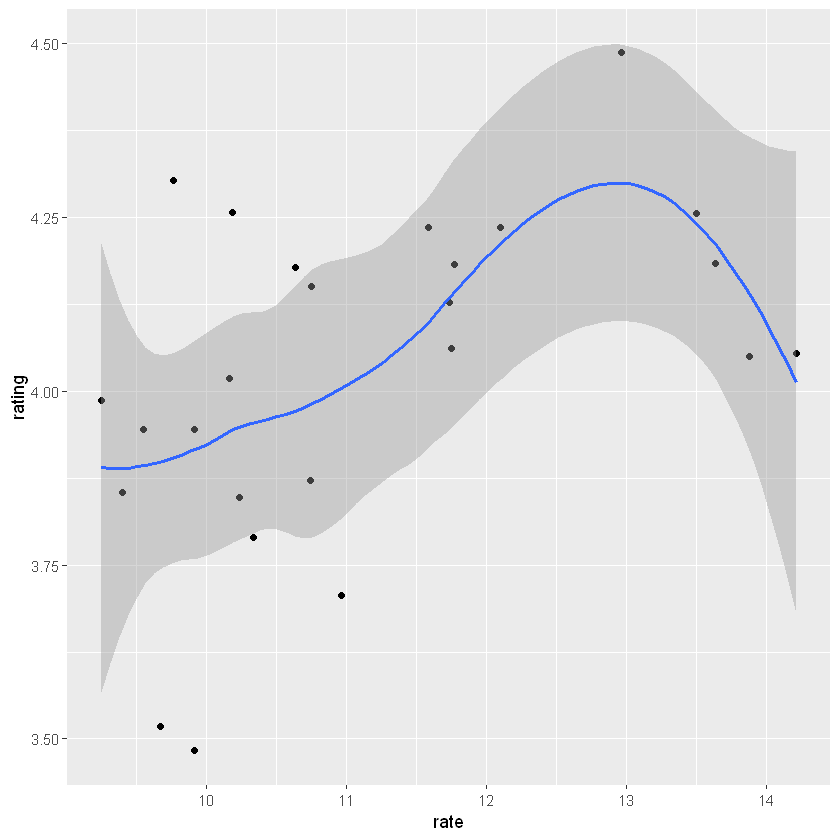

In [18]:
# Q3 - stratify movies by rating per year, plot average rating vs rating per year
movielens %>% 
  filter(year >= 1993) %>%
  group_by(movieId) %>%
  summarize(n = n(), years = 2018 - first(year),
            title = title[1],
            rating = mean(rating)) %>%
  mutate(rate = n/years) %>%
  top_n(25, rate) %>%
  arrange(desc(rate)) %>%
  ggplot(aes(rate, rating)) +
  geom_point() +
  geom_smooth()

# Q4 - given Q3, which value would be most appropriate to fill blank entries
    # ANSWER - Fill in the missing values with a lower value than the average rating

In [19]:
# Q5 - process the timestamp data into a usable date format
movielens <- mutate(movielens, date = as_datetime(timestamp))
movielens

movieId,title,year,genres,userId,rating,timestamp,date
31,Dangerous Minds,1995,Drama,1,2.5,1260759144,2009-12-14 02:52:24
1029,Dumbo,1941,Animation|Children|Drama|Musical,1,3.0,1260759179,2009-12-14 02:52:59
1061,Sleepers,1996,Thriller,1,3.0,1260759182,2009-12-14 02:53:02
1129,Escape from New York,1981,Action|Adventure|Sci-Fi|Thriller,1,2.0,1260759185,2009-12-14 02:53:05
1172,Cinema Paradiso (Nuovo cinema Paradiso),1989,Drama,1,4.0,1260759205,2009-12-14 02:53:25
1263,"Deer Hunter, The",1978,Drama|War,1,2.0,1260759151,2009-12-14 02:52:31
1287,Ben-Hur,1959,Action|Adventure|Drama,1,2.0,1260759187,2009-12-14 02:53:07
1293,Gandhi,1982,Drama,1,2.0,1260759148,2009-12-14 02:52:28
1339,Dracula (Bram Stoker's Dracula),1992,Fantasy|Horror|Romance|Thriller,1,3.5,1260759125,2009-12-14 02:52:05
1343,Cape Fear,1991,Thriller,1,2.0,1260759131,2009-12-14 02:52:11


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


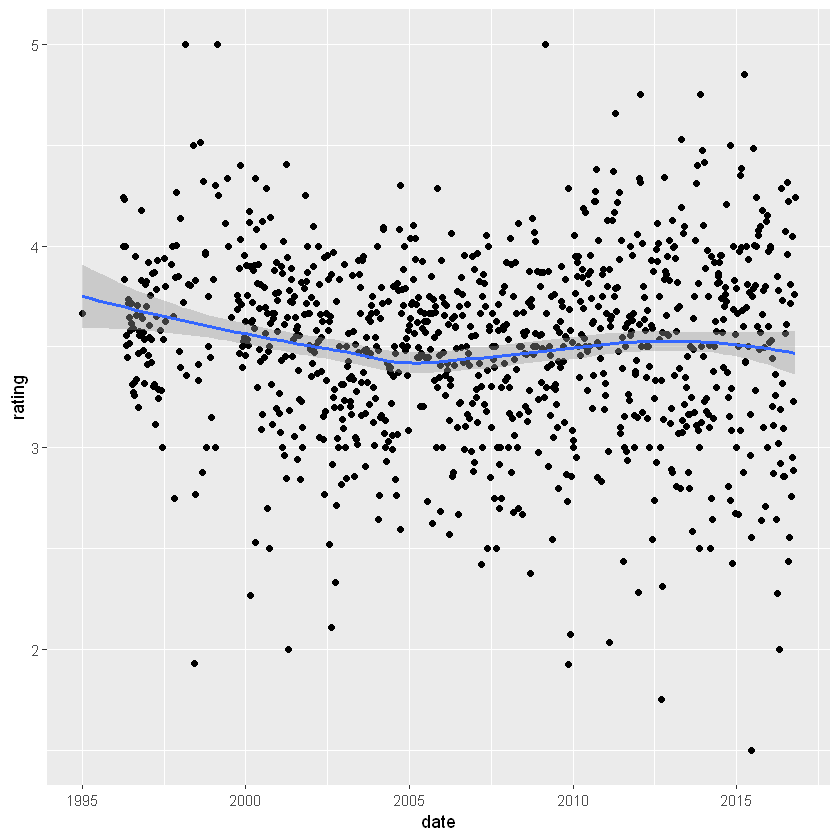

In [20]:
# Q6 - compute the average rating for each week, plot against date
movielens %>% 
  mutate(date = round_date(date, unit = "week")) %>%
  group_by(date) %>%
  summarize(rating = mean(rating)) %>%
  ggplot(aes(date, rating)) +
  geom_point() +
  geom_smooth()

# Q7 - given Q6, which formula is the most appropriate
    # ANSWER - Yu,i=μ+bi+bu+f(du,i)+εu,i , with f a smooth function of du,i


genres,n,years,title,rating,rate
Comedy,6748,23,"Brothers McMullen, The",3.273266,293.39130
Comedy|Romance,3973,23,Clueless,3.369872,172.73913
Action|Adventure|Thriller,1413,23,GoldenEye,3.378273,61.43478
Comedy|Crime,1096,59,Some Like It Hot,3.406478,18.57627
Drama|Thriller,1402,24,Disclosure,3.457917,58.41667
Action|Crime|Thriller,1441,47,"French Connection, The",3.481610,30.65957
Action|Adventure|Sci-Fi|Thriller,1453,37,Escape from New York,3.486579,39.27027
Action|Adventure|Sci-Fi,2146,36,Tron,3.582945,59.61111
Action|Sci-Fi|Thriller,1065,36,Blade Runner,3.612676,29.58333
Comedy|Drama|Romance,3204,23,Mighty Aphrodite,3.621879,139.30435


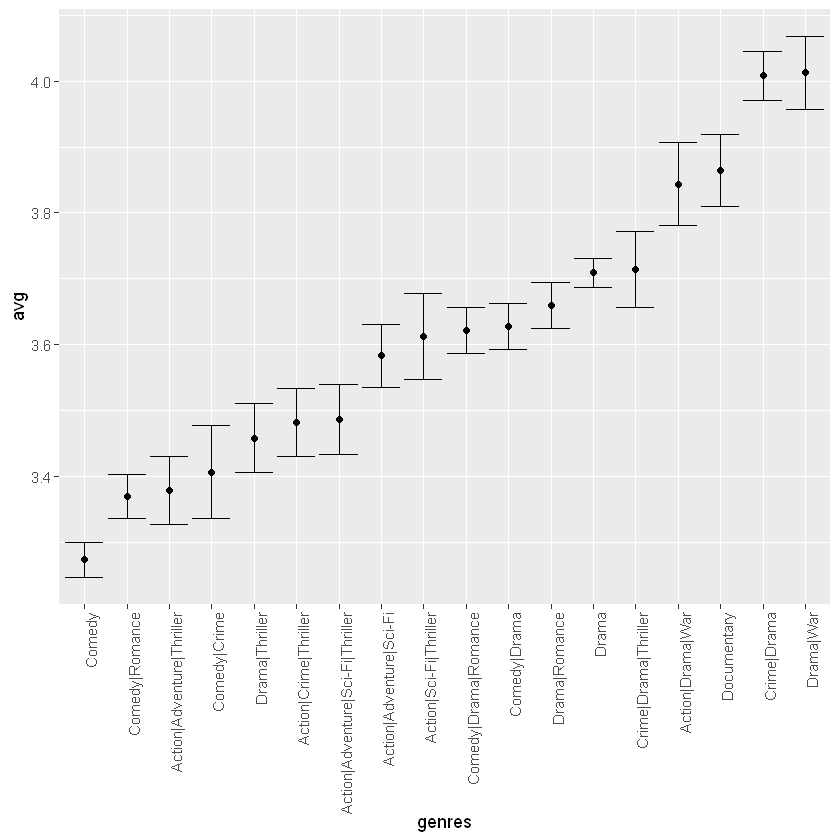

In [21]:
# Q8 - define a category for the ratings, which has the lowest average rating
movielens %>%
  group_by(genres) %>%
  summarize(n = n(), years = 2018 - first(year),
            title = title[1],
            rating = mean(rating)) %>%
  filter(n >= 1000) %>%
  mutate(rate = n/years) %>%
  top_n(25, rate) %>%
  arrange(rating)
    
    # EDX CORRECT ANSWER
    movielens %>% group_by(genres) %>%
      summarize(n = n(), avg = mean(rating), se = sd(rating)/sqrt(n())) %>%
      filter(n >= 1000) %>% 
      mutate(genres = reorder(genres, avg)) %>%
      ggplot(aes(x = genres, y = avg, ymin = avg - 2*se, ymax = avg + 2*se)) + 
      geom_point() +
      geom_errorbar() + 
      theme(axis.text.x = element_text(angle = 90, hjust = 1))

# Q9 - given Q8, which formula is the most appropriate
    # ANSWER - Yu,i=μ+bi+bu+∑Kk=1xku,iβk+εu,i, with xku,i=1 if gu,i is genre k

In [22]:
# config
library(tidyverse)
library(dslabs)
options(digits=7)

# building the data

    # simulate the student numbers
    set.seed(1986, sample.kind="Rounding")
    n <- round(2^rnorm(1000, 8, 1))
    
    # assign the true quality for each school
    set.seed(1, sample.kind="Rounding")
    mu <- round(80+2*rt(1000,5))
    range(mu)
    schools <- tibble(id = paste("PS",1:1000),
                      size = n,
                      quality = mu,
                      rank = rank(-mu))
    
        # display the top 10
        schools %>% 
          top_n(10, quality) %>%
          arrange(desc(quality))

    # now we have the students take a test
    set.seed(1, sample.kind="Rounding")
    mu <- round(80+2*rt(1000,5))    
    scores <- sapply(1:nrow(schools), function(i){
        scores <- rnorm(schools$size[i], schools$quality[i], 30)
        scores
    })

    schools <- schools %>%
        mutate(score=sapply(scores, mean))

    schools    


Warning message in set.seed(1986, sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"Warning message in set.seed(1, sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"

[1] 67 94

id,size,quality,rank
PS 191,1036,94,1.0
PS 567,121,93,2.0
PS 95,235,91,3.0
PS 430,61,90,4.0
PS 343,78,89,5.0
PS 981,293,88,6.0
PS 558,196,87,7.0
PS 79,105,86,13.5
PS 113,653,86,13.5
PS 163,300,86,13.5


Warning message in set.seed(1, sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"

id,size,quality,rank,score
PS 1,248,79,696.0,82.20965
PS 2,311,79,696.0,82.76347
PS 3,305,81,330.5,80.10790
PS 4,131,79,696.0,74.37327
PS 5,360,80,516.5,79.13786
PS 6,158,81,330.5,80.35375
PS 7,452,79,696.0,80.12036
PS 8,157,80,516.5,77.43649
PS 9,86,82,194.5,79.73894
PS 10,117,82,194.5,78.58280


In [23]:
# Q1 - show the top 10 schools, report the ID to the top, average of the 10th
top_10 <- schools %>%
    top_n(10, score) %>%
    arrange(desc(score))

top_10


id,size,quality,rank,score
PS 567,121,93,2.0,95.84170
PS 191,1036,94,1.0,93.54249
PS 330,162,84,53.5,90.99615
PS 701,83,83,104.5,90.50055
PS 591,213,83,104.5,89.74194
PS 205,172,85,28.5,89.28585
PS 574,199,84,53.5,89.19625
PS 963,208,86,13.5,89.00446
PS 430,61,90,4.0,88.72107
PS 756,245,83,104.5,87.95731


In [24]:
# Q2 - what is the median school size overall, what is the median school size of the top 10
median(schools$size)
median(top_10$size)

[1] 261

[1] 185.5

In [25]:
# Q3 - we see that smaller schools produce better results, do the same analysis as Q1-2 on the bottom
bottom_10 <- schools %>%
    arrange(score) %>%
    head(10)

median(bottom_10$size)

[1] 219

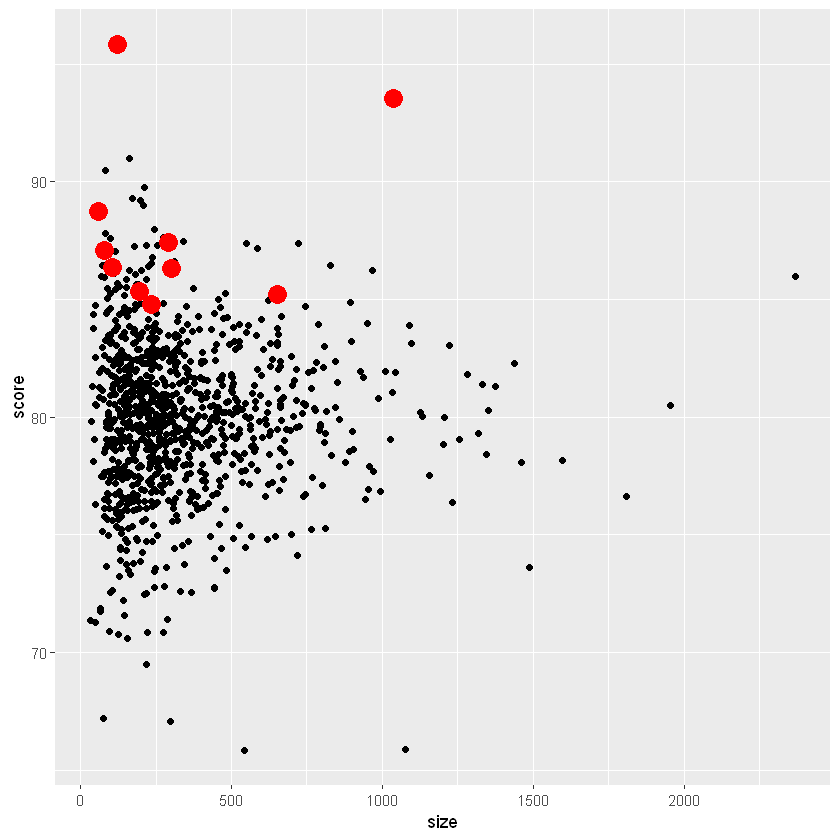

In [26]:
# Q4 - plot size vs score, highlight the top 10 based on true quality
top_10_true <- schools %>%
    arrange(desc(quality)) %>%
    head(10)

schools %>%
    ggplot(aes(size, score)) +
    geom_point() +
    geom_point(data=top_10_true, aes(size, score), color="red", size=5)


In [37]:
# Q5 - regularise the data, what is the top school after?
overall <- mean(sapply(scores, mean))
alpha <- 25
score_reg <- sapply(scores, function(x) overall + sum(x-overall)/length(x)+alpha)

reg_schools<- schools %>%
    mutate(score_reg=score_reg) %>%
    top_n(10, score_reg) %>% arrange(desc(score_reg))

In [38]:
reg_schools

id,size,quality,rank,score,score_reg
PS 567,121,93,2.0,95.84170,120.8417
PS 191,1036,94,1.0,93.54249,118.5425
PS 330,162,84,53.5,90.99615,115.9961
PS 701,83,83,104.5,90.50055,115.5005
PS 591,213,83,104.5,89.74194,114.7419
PS 205,172,85,28.5,89.28585,114.2859
PS 574,199,84,53.5,89.19625,114.1963
PS 963,208,86,13.5,89.00446,114.0045
PS 430,61,90,4.0,88.72107,113.7211
PS 756,245,83,104.5,87.95731,112.9573


id,size,quality,rank,score,just_the_sum,n_i
PS 1,248,79,696.0,82.20965,546.69595,248
PS 2,311,79,696.0,82.76347,857.81253,311
PS 3,305,81,330.5,80.10790,31.31450,305
PS 4,131,79,696.0,74.37327,-737.78713,131
PS 5,360,80,516.5,79.13786,-312.25374,360
PS 6,158,81,330.5,80.35375,55.06668,158
PS 7,452,79,696.0,80.12036,52.04137,452
PS 8,157,80,516.5,77.43649,-403.29249,157
PS 9,86,82,194.5,79.73894,-22.90073,86
PS 10,117,82,194.5,78.58280,-166.42352,117


[1] 135

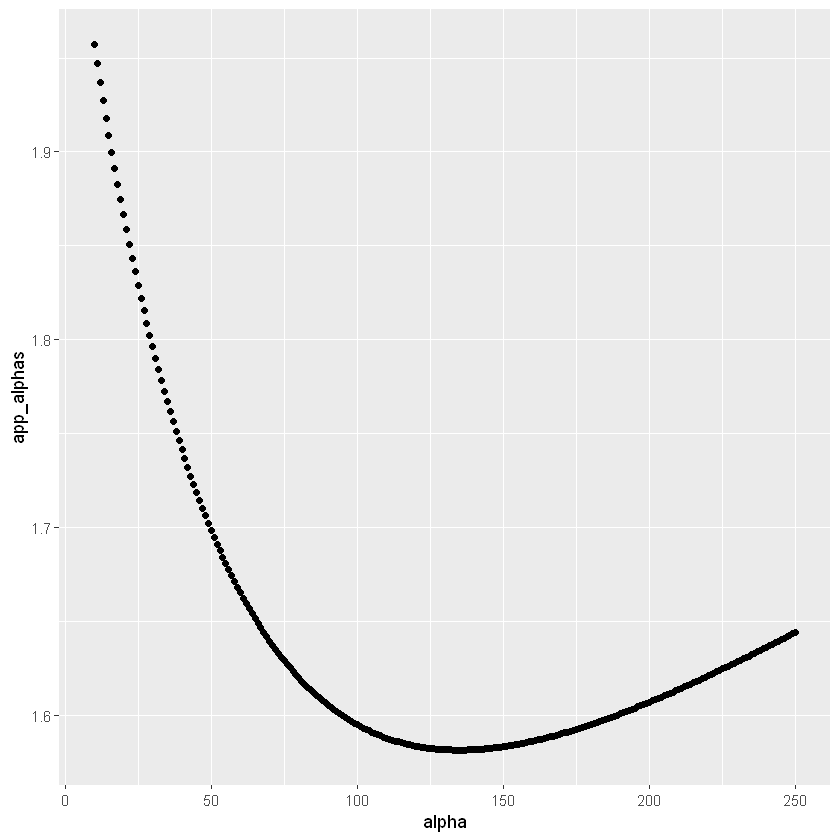

[1] 135

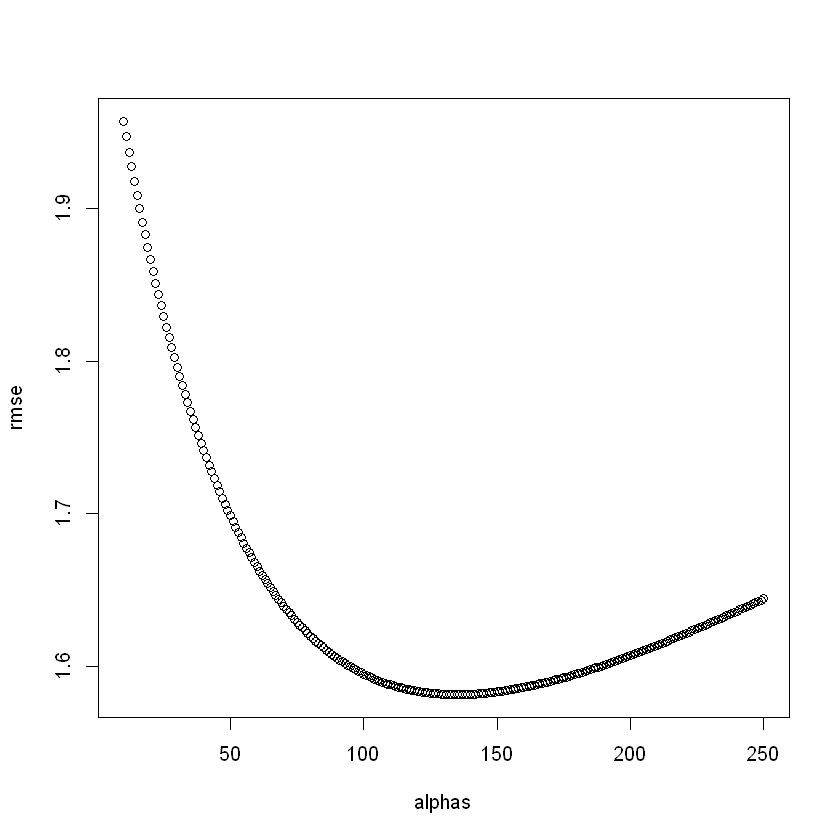

In [39]:
# Q6 - find teh best alpha from 10 to 250
alpha <- seq(10,250)

overall <- mean(sapply(scores, mean))
just_the_sum <- sapply(scores, function(x) sum(x-overall))
n_i <- sapply(scores, function(x) length(x))

schools_wo_alpha <- schools %>%
    mutate(just_the_sum=just_the_sum, n_i=n_i)

schools_wo_alpha

app_alphas <- sapply(alpha, function(a){
    predicted_ratings <- schools_wo_alpha %>%
        mutate(reg_scores=just_the_sum/(n_i+a)) %>%
        mutate(pred = overall+reg_scores) %>%
        .$pred
    return(RMSE(predicted_ratings, schools$quality))
})

qplot(alpha, app_alphas)
alpha[which.min(app_alphas)]
    #EDX CORRECT ANSWER
    alphas <- seq(10,250)
    rmse <- sapply(alphas, function(alpha){
        score_reg <- sapply(scores, function(x) overall+sum(x-overall)/(length(x)+alpha))
        sqrt(mean((score_reg - schools$quality)^2))
    })
    plot(alphas, rmse)
    alphas[which.min(rmse)]


In [40]:
# Q7 - rank the schools based on the new averages, ID of top school, regularised avg score of 10th
overall <- mean(sapply(scores, mean))
alpha <- 135
score_reg <- sapply(scores, function(x) overall + sum(x-overall)/(length(x)+alpha))

reg_schools<- schools %>%
    mutate(score_reg=score_reg) %>%
    top_n(10, score_reg) %>% arrange(desc(score_reg))

reg_schools

id,size,quality,rank,score,score_reg
PS 191,1036,94,1.0,93.54249,91.98183
PS 567,121,93,2.0,95.84170,87.49043
PS 561,723,86,13.5,87.39858,86.23529
PS 330,162,84,53.5,90.99615,86.00028
PS 591,213,83,104.5,89.74194,85.96477
PS 400,550,86,13.5,87.38269,85.92873
PS 865,586,86,13.5,87.17508,85.83260
PS 266,2369,86,13.5,85.98176,85.65954
PS 563,828,86,13.5,86.45072,85.54714
PS 574,199,84,53.5,89.19625,85.48132


[1] 10

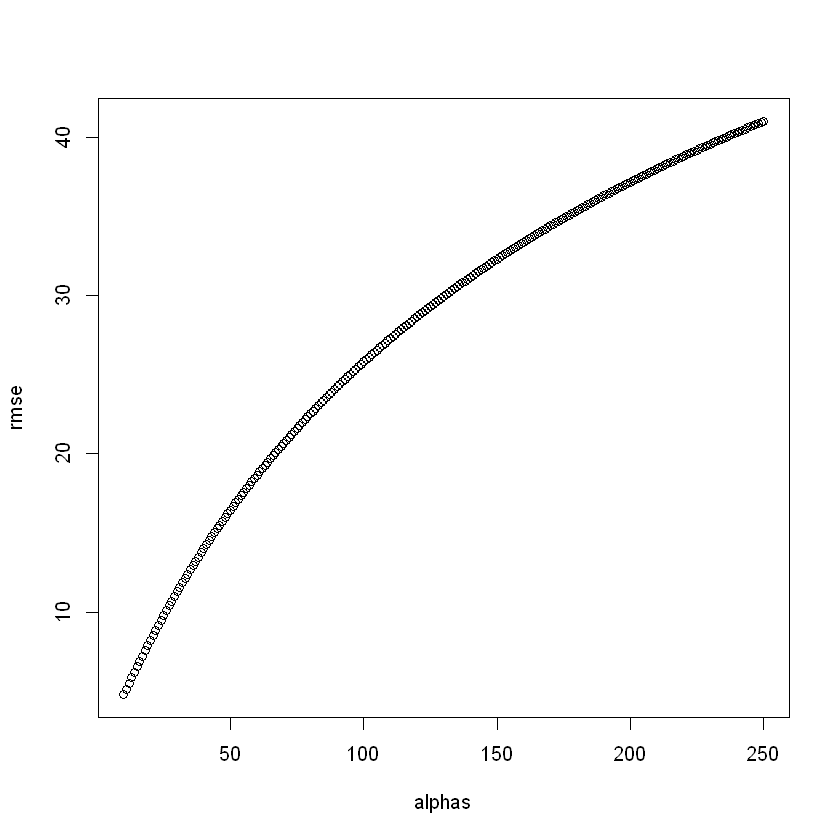

In [41]:
# Q8 - a common mistake is shrinking values towards 0 that arent centered areound 0
#    - if we dont subtract the overall average before shrinking, what value of alpha gives the minimum RMSE
alphas <- seq(10,250)
rmse <- sapply(alphas, function(alpha){
    score_reg <- sapply(scores, function(x) sum(x)/(length(x)+alpha))
    sqrt(mean((score_reg - schools$quality)^2))
})
plot(alphas, rmse)
alphas[which.min(rmse)]

In [42]:
# config
library(tidyverse)
library(dslabs)

# building the student data
set.seed(1987, sample.kind="Rounding")
n <- 100
k <- 8
Sigma <- 64* matrix(c(1, .75, .5, .75, 1, .5, .5, .5, 1), 3, 3)
m <- MASS::mvrnorm(n, rep(0, 3), Sigma)
m <- m[order(rowMeans(m), decreasing = TRUE),]
y <- m %x% matrix(rep(1, k), nrow = 1) + matrix(rnorm(matrix(n*k*3)), n, k*3)
colnames(y) <- c(paste(rep("Math",k), 1:k, sep="_"),
                 paste(rep("Science",k), 1:k, sep="_"),
                 paste(rep("Arts",k), 1:k, sep="_"))

Warning message in set.seed(1987, sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"

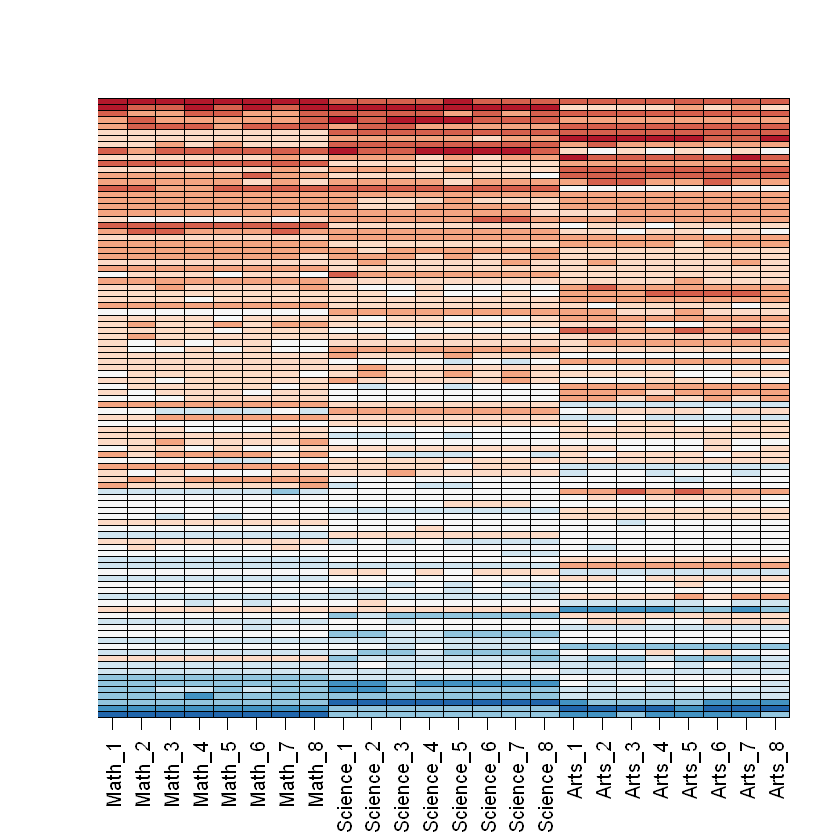

In [43]:
# Q1 - visualise the 24 test scores by plotting an image
my_image <- function(x, zlim = range(x), ...){
  colors = rev(RColorBrewer::brewer.pal(9, "RdBu"))
  cols <- 1:ncol(x)
  rows <- 1:nrow(x)
  image(cols, rows, t(x[rev(rows),, drop=FALSE]), xaxt = "n", yaxt = "n",
        xlab="", ylab="", col = colors, zlim=zlim, ...)
  abline(h=rows + 0.5, v=cols+0.5)
  axis(side=1, cols, colnames(x), las = 2)
}

my_image(y)

[1] 0.4855371 1.0000000

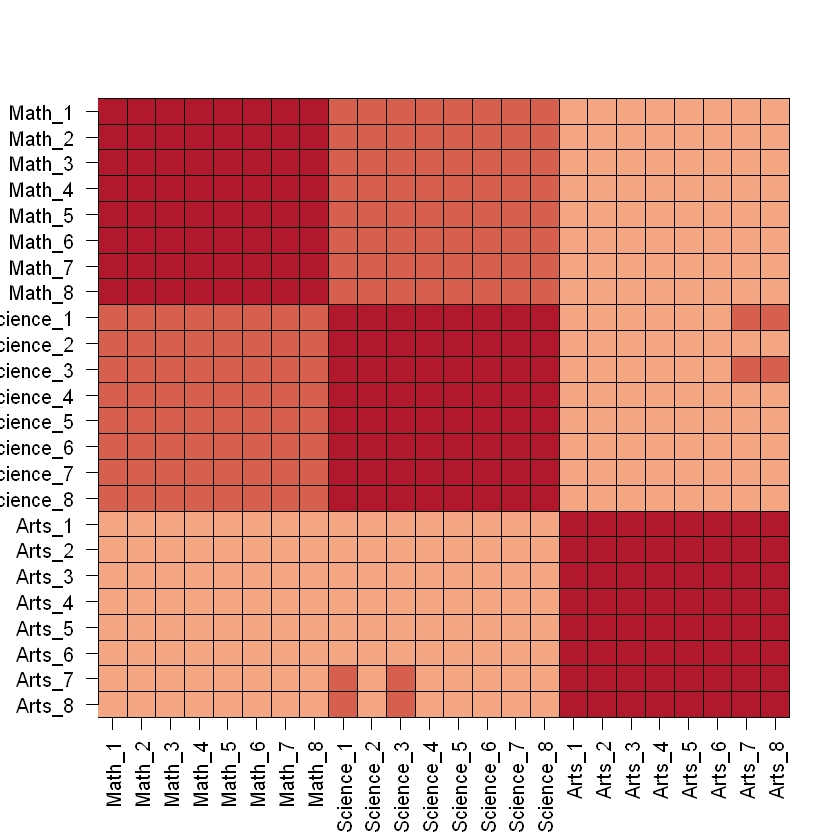

In [44]:
# Q2 - examine the correlation between the tests, and describe the findings
my_image(cor(y), zlim = c(-1,1))
range(cor(y))
axis(side=2, 1:ncol(y), rev(colnames(y)), las = 2)
    
    # ans - There is correlation among all tests, but higher if the tests are in science and math and even higher within each subject.

In [45]:
# Q3 - use the svd() function, this returns the orthognals of y
#      compute the sum of squares for Y, YV; confirming they're the same
s <- svd(y)
names(s)

y_svd <- s$u %*% diag(s$d) %*% t(s$v)
max(abs(y - y_svd))

ss_y <- apply(y^2, 2, sum)
ss_vy <- apply((y%*%s$v)^2, 2, sum)
sum(ss_y)
sum(ss_vy)

[1] "d" "u" "v"

[1] 3.552714e-14

[1] 175434.6

[1] 175434.6

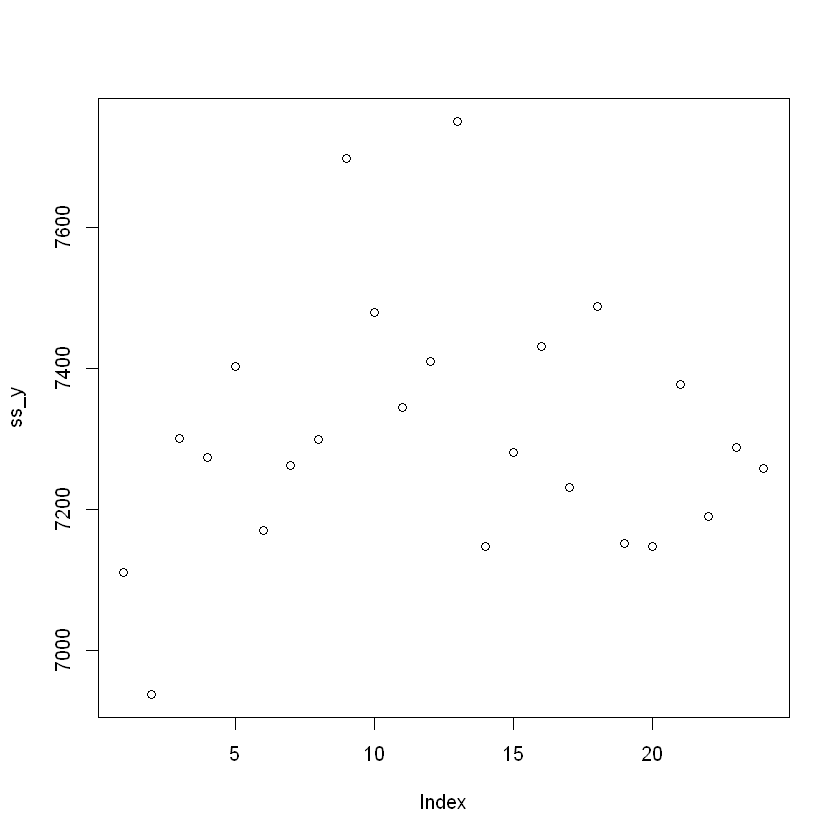

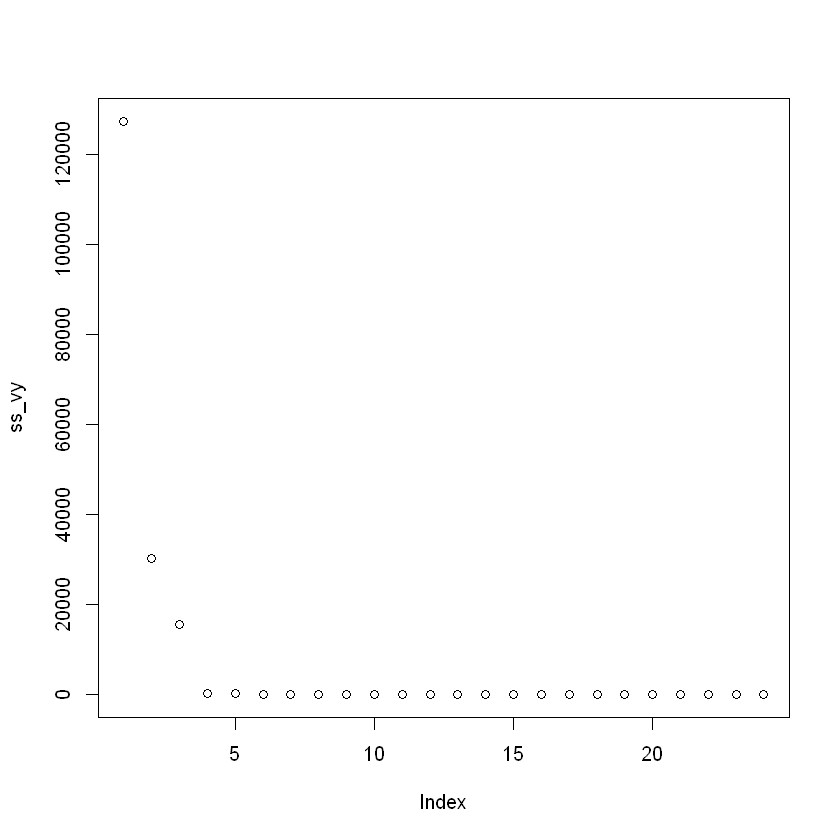

In [46]:
# Q4 - plot ss_y against the column number and do the same for ss_yv, report
plot(ss_y)
plot(ss_vy)

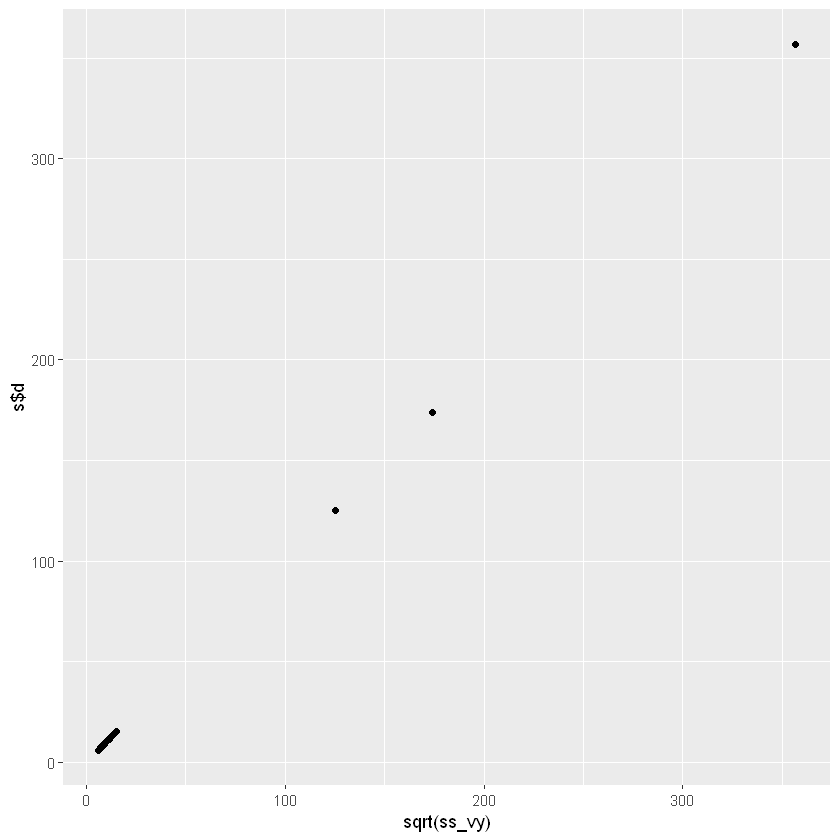

In [47]:
# Q5 - plot the sqrt(ss_vy) against the s$d, report
qplot(sqrt(ss_vy), s$d)


In [48]:
# Q6 - compute the variability of the first 3 columns of VY, report proportion
cumsum(ss_vy/sum(ss_vy))

[1] 0.7259777 0.8984487 0.9877922 0.9890723 0.9901679 0.9910979 0.9919975
 [8] 0.9928368 0.9935894 0.9942546 0.9949117 0.9955172 0.9960670 0.9965890
[15] 0.9970603 0.9975163 0.9979282 0.9983161 0.9986639 0.9989963 0.9992877
[22] 0.9995635 0.9997976 1.0000000

# Q7 - use the sweep() to compute UD without constructing diag(s$d) or using matrix multiplication
#    - this is a useful trick to avoid creating the matrix diag(s$d)
identical(s$u %*% diag(s$d), sweep(s$u, 2, s$d, FUN = "*"))


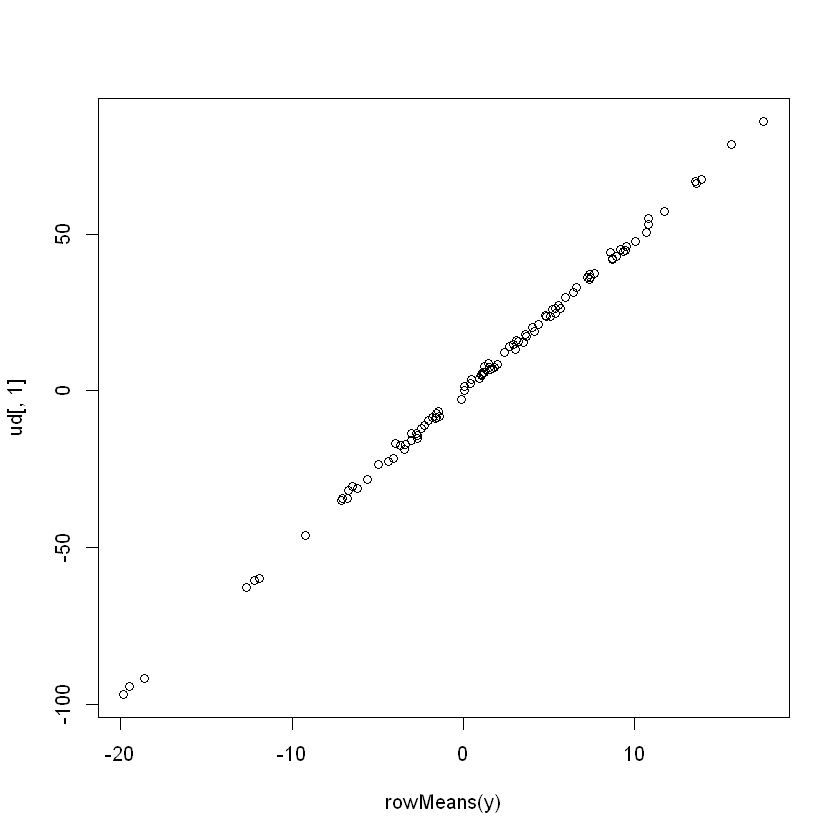

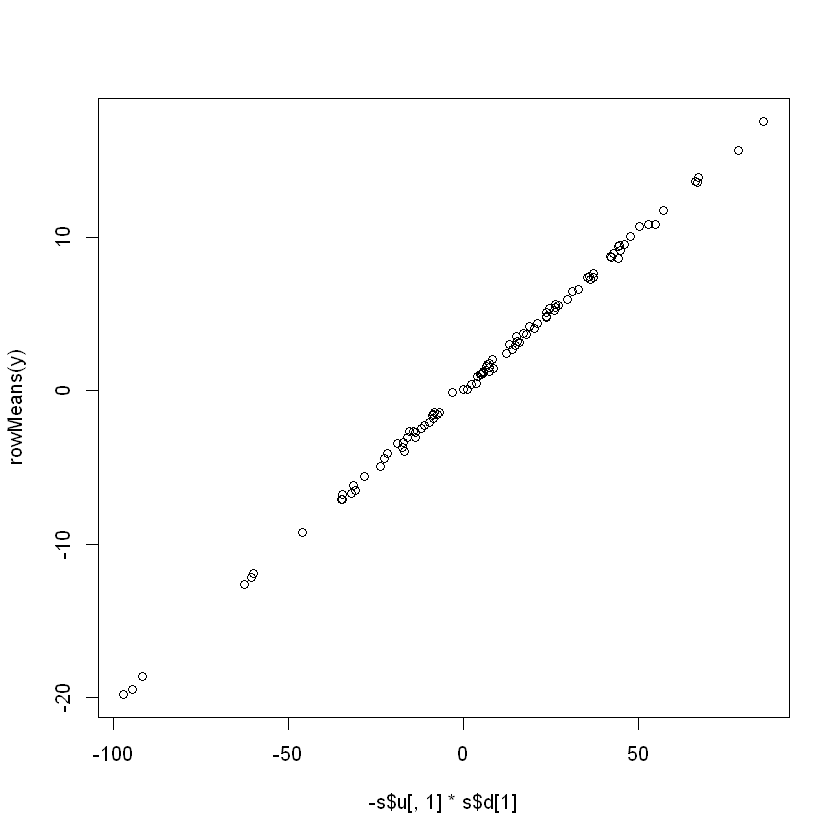

In [49]:
# Q8 - compute the average score for each student, plot it against U1d1,1
ud <- sweep(-s$u, 2, s$d, FUN = "*")
plot(rowMeans(y), ud[,1])

    # EDX CORRECT ANSWER
    plot(-s$u[,1]*s$d[1], rowMeans(y))

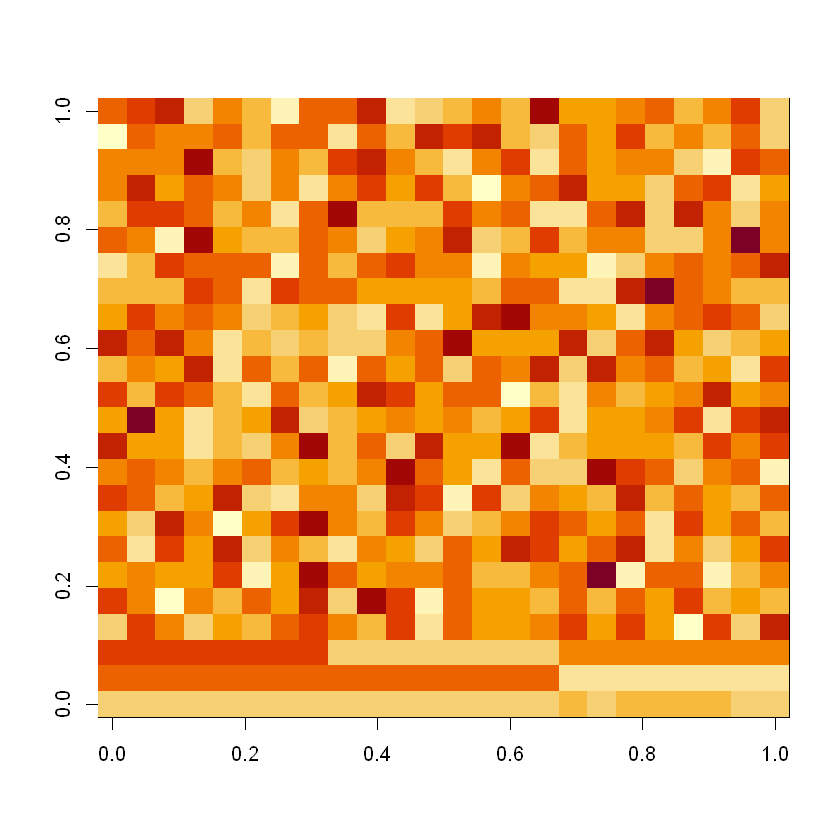

In [50]:
# Q9 - make and image plot of V, describe the first column relative to the others
image(s$v)

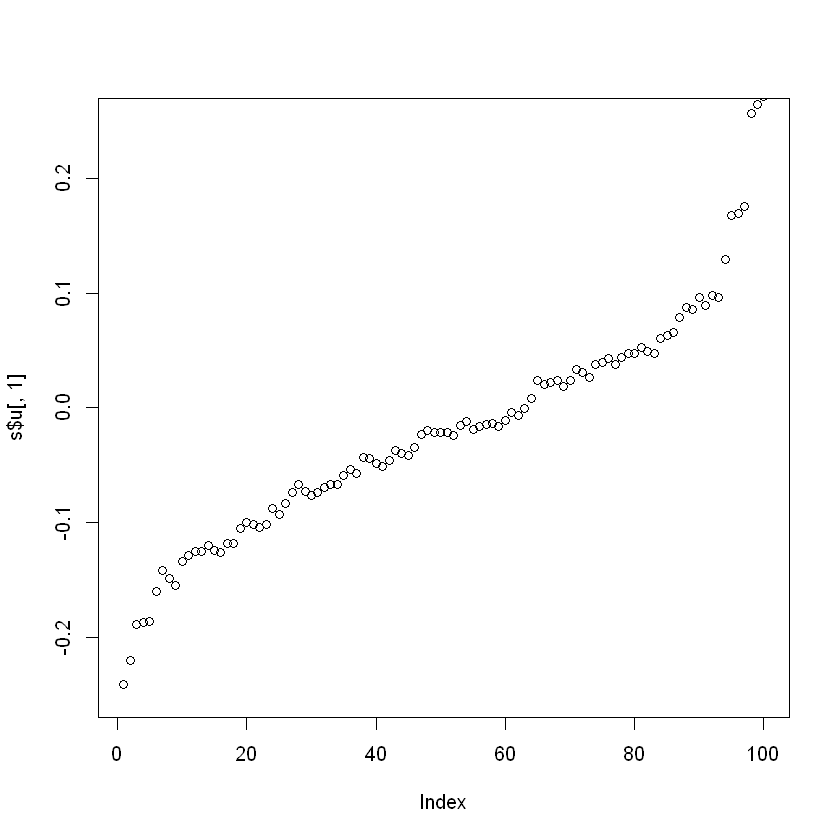

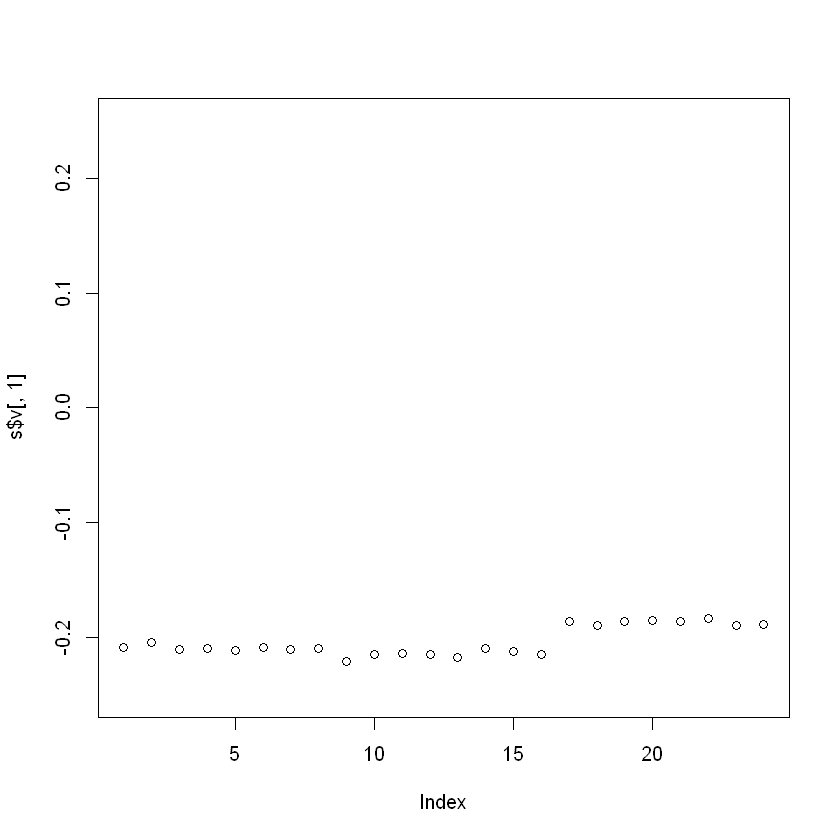

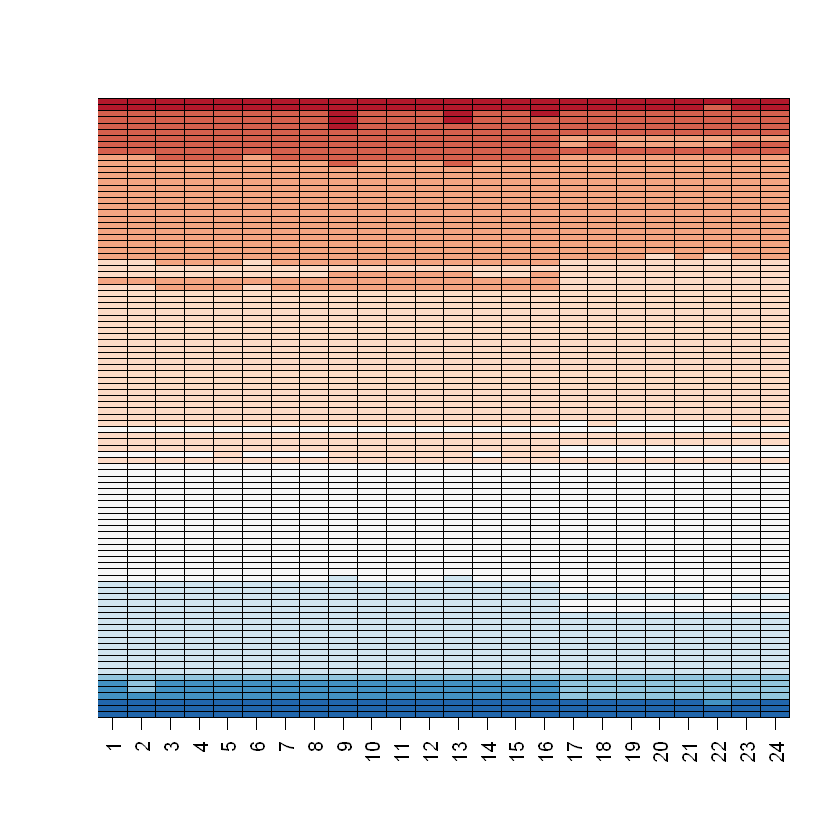

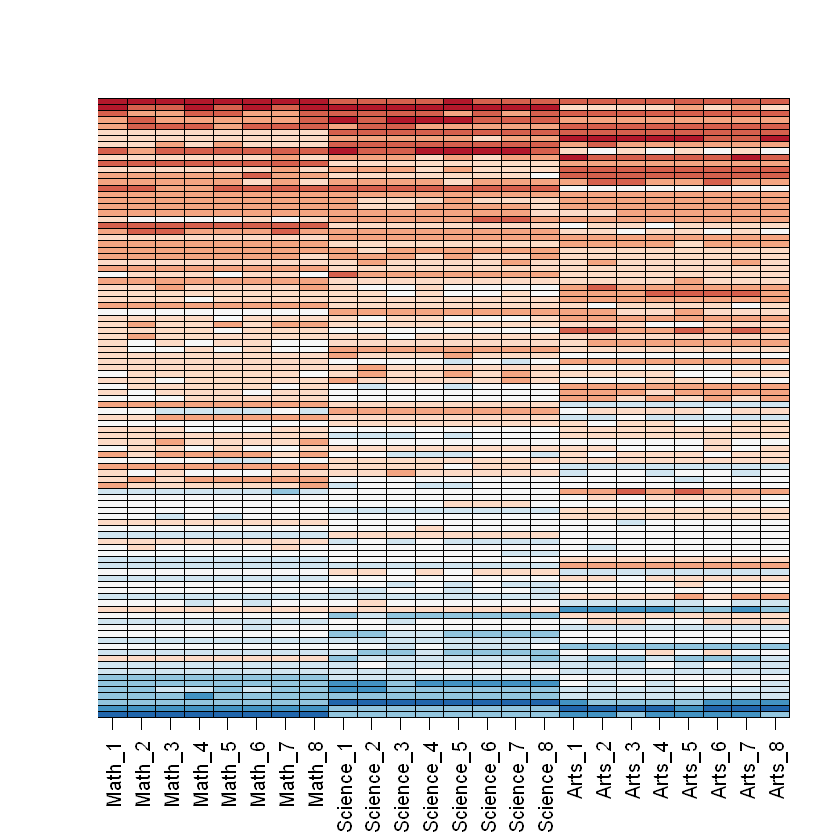

In [51]:
# Q10 - plot U1, then plot V1T, using the same range for the y-axis
#     - make an image of U1d1,1V1T
plot(s$u[,1], ylim = c(-0.25, 0.25))
plot(s$v[,1], ylim = c(-0.25, 0.25))
with(s, my_image((u[, 1, drop=FALSE]*d[1]) %*% t(v[, 1, drop=FALSE])))
my_image(y)
    # with a vector length of 100, and a vector of 24, we can come close to the 100x24 matrix
    # this is our first matrix factorisation


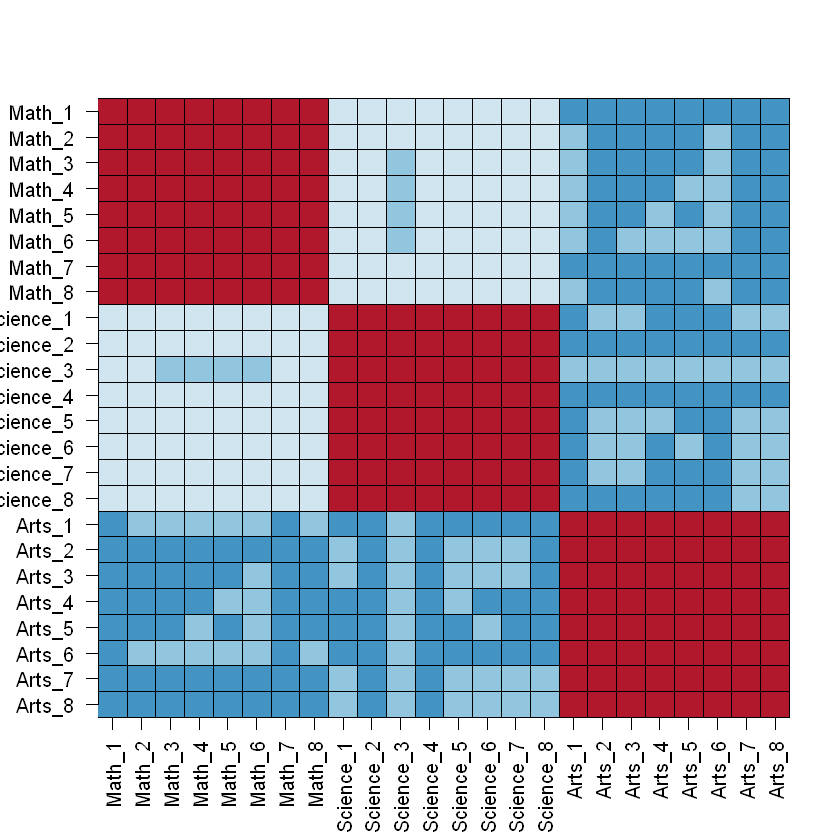

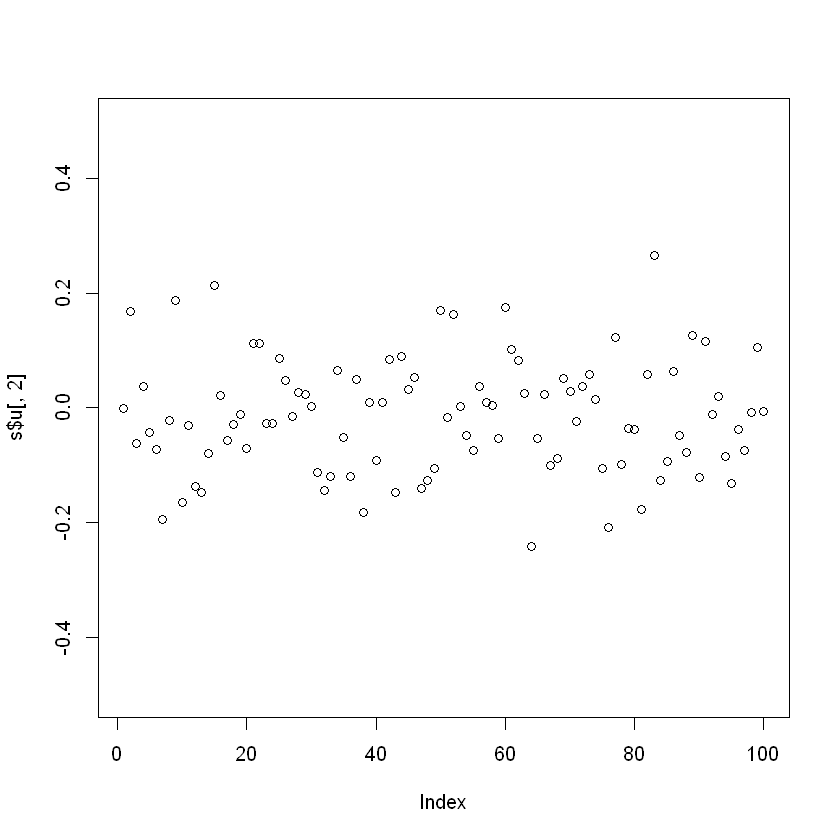

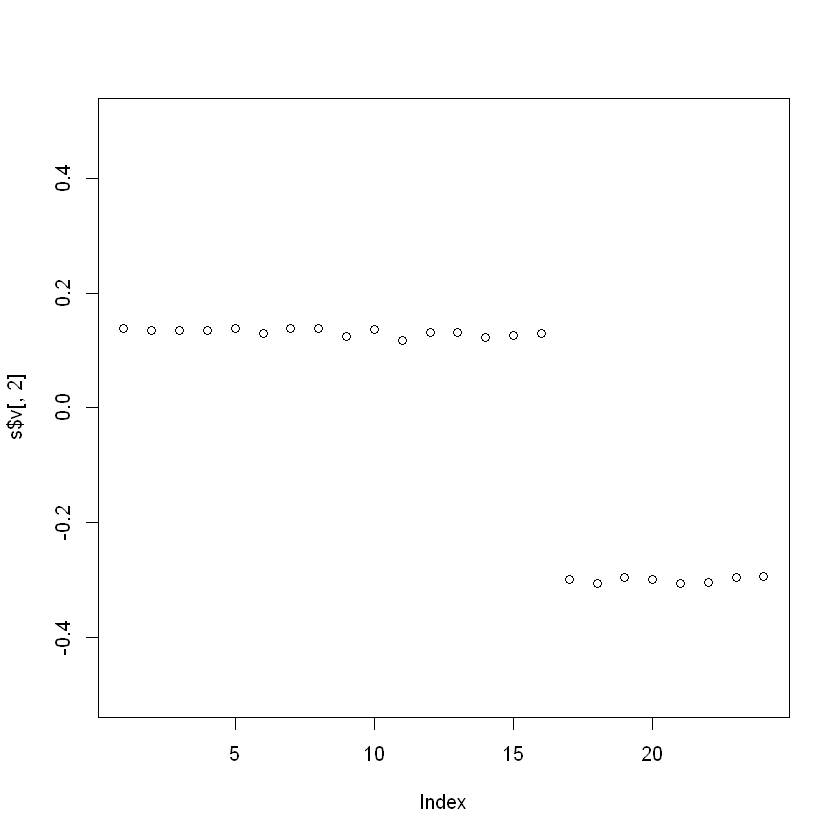

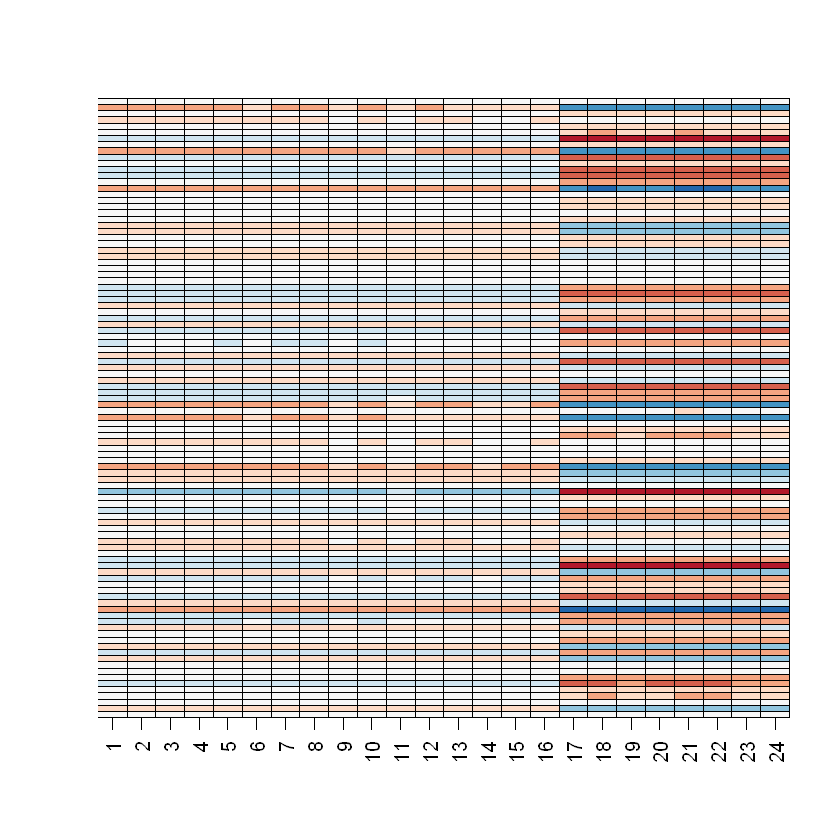

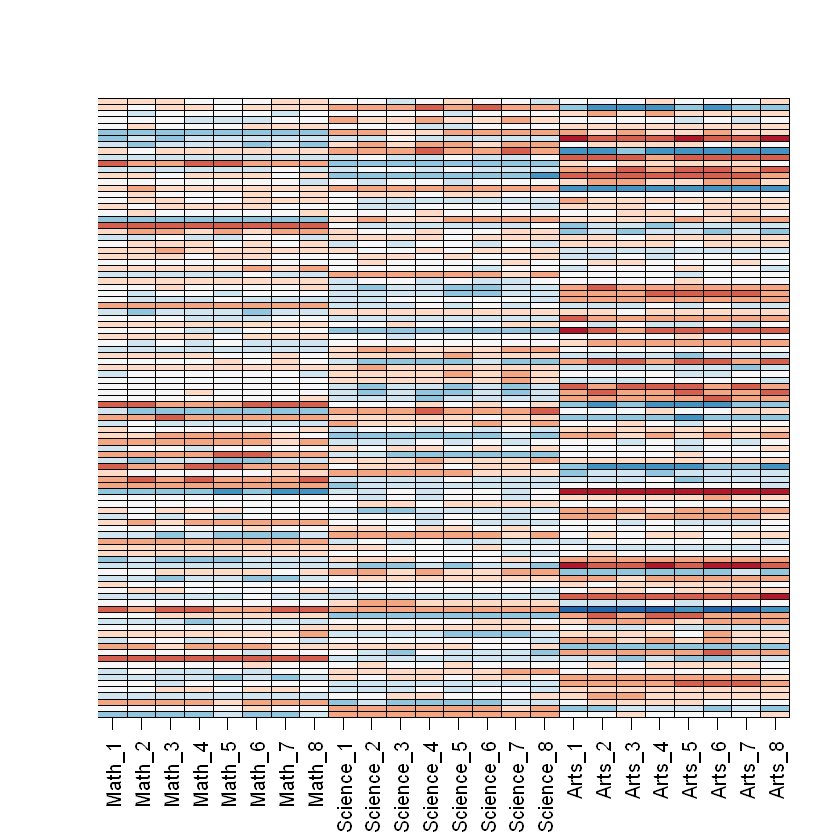

In [52]:
# Q11 - in Q6 we calculated the total variability, 
#     - our approximation only explains the observation that good students are good in all subjects
#     - it doesnt explain the higher similarity within subject, we can see this:
resid <- y - with(s,(u[, 1, drop=FALSE]*d[1]) %*% t(v[, 1, drop=FALSE]))
my_image(cor(resid), zlim = c(-1,1))
axis(side = 2, 1:ncol(y), rev(colnames(y)), las = 2)

    # - make an image of U2d2,2V2T and compare it to the resid image
    plot(s$u[,2], ylim = c(-0.5, 0.5))
    plot(s$v[,2], ylim = c(-0.5, 0.5))
    with(s, my_image((u[, 2, drop=FALSE]*d[2]) %*% t(v[, 2, drop=FALSE])))
    my_image(resid)


[1] 89.84487

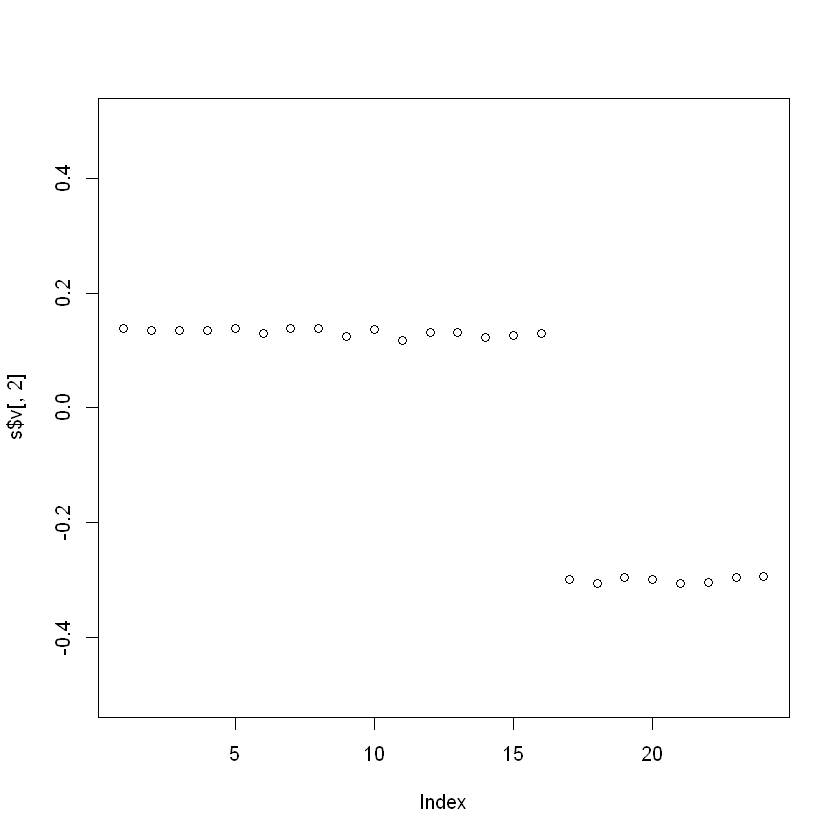

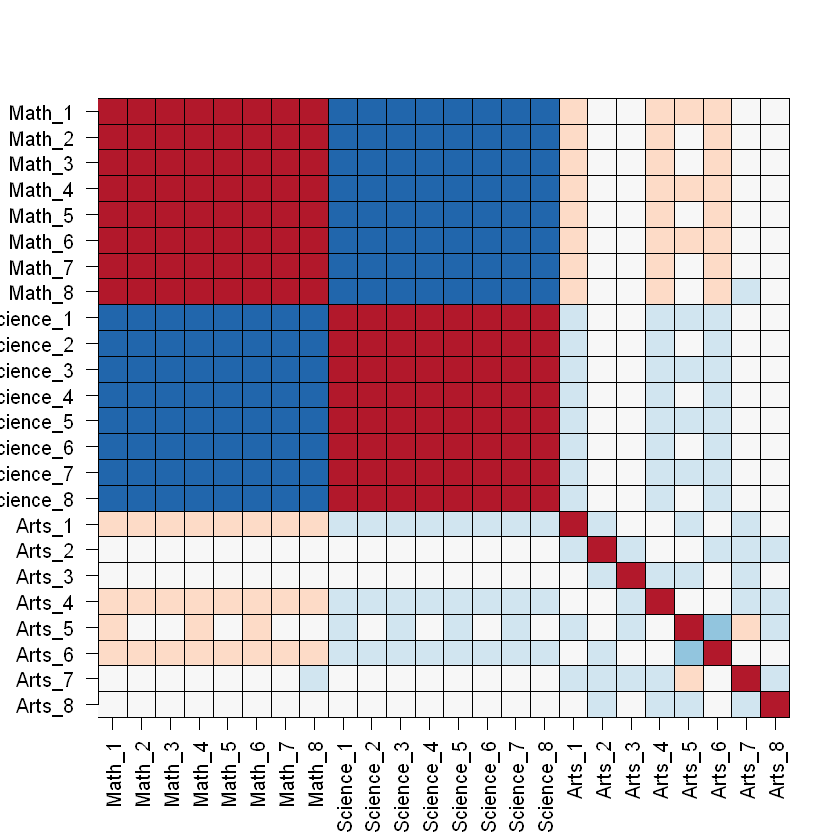

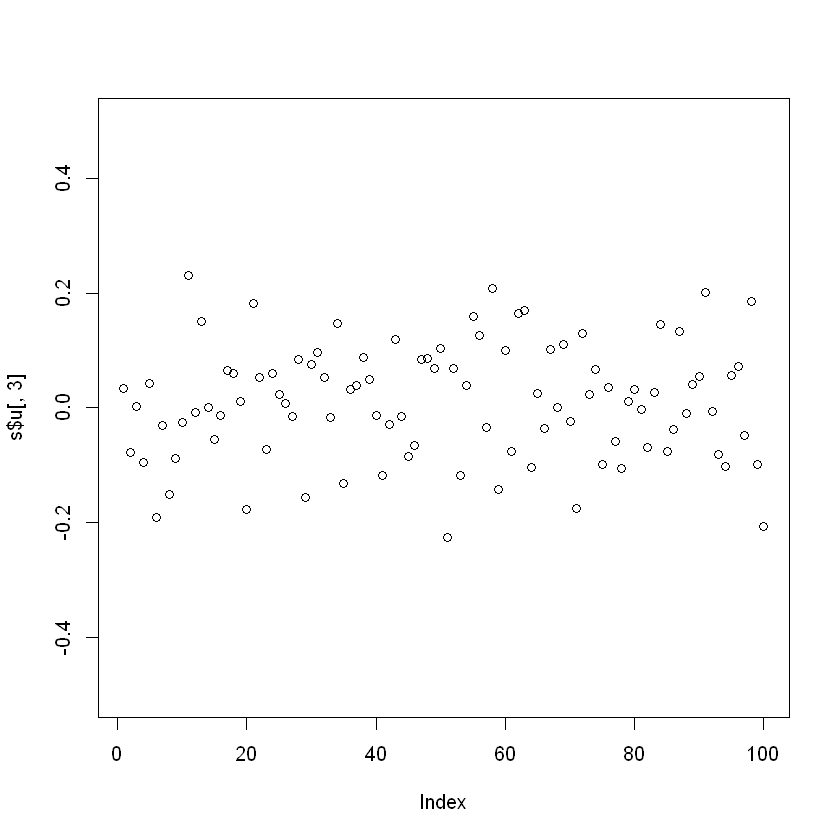

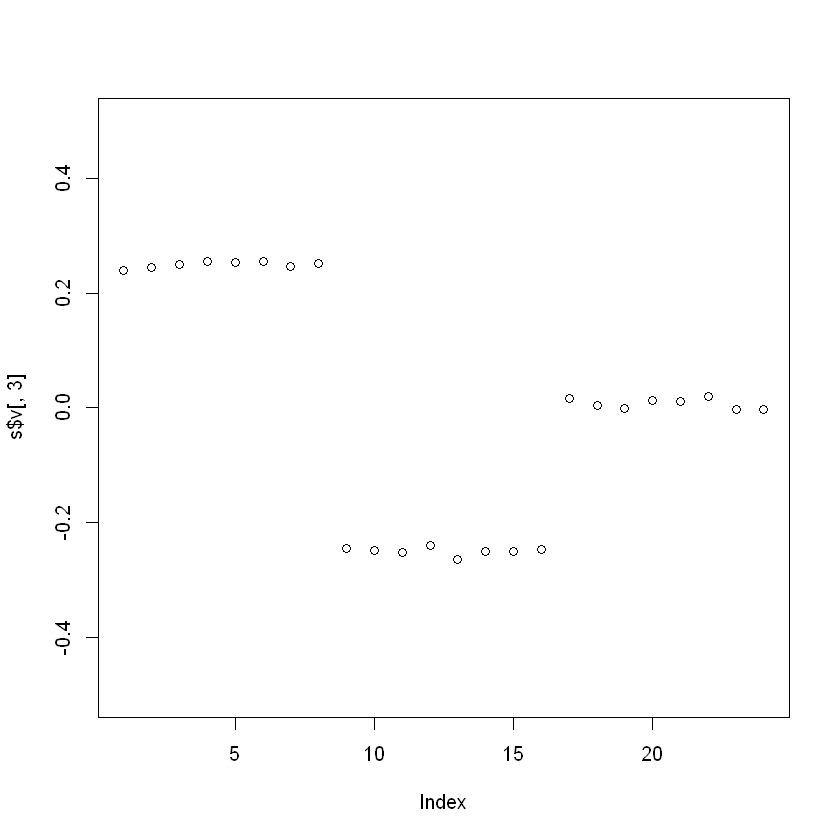

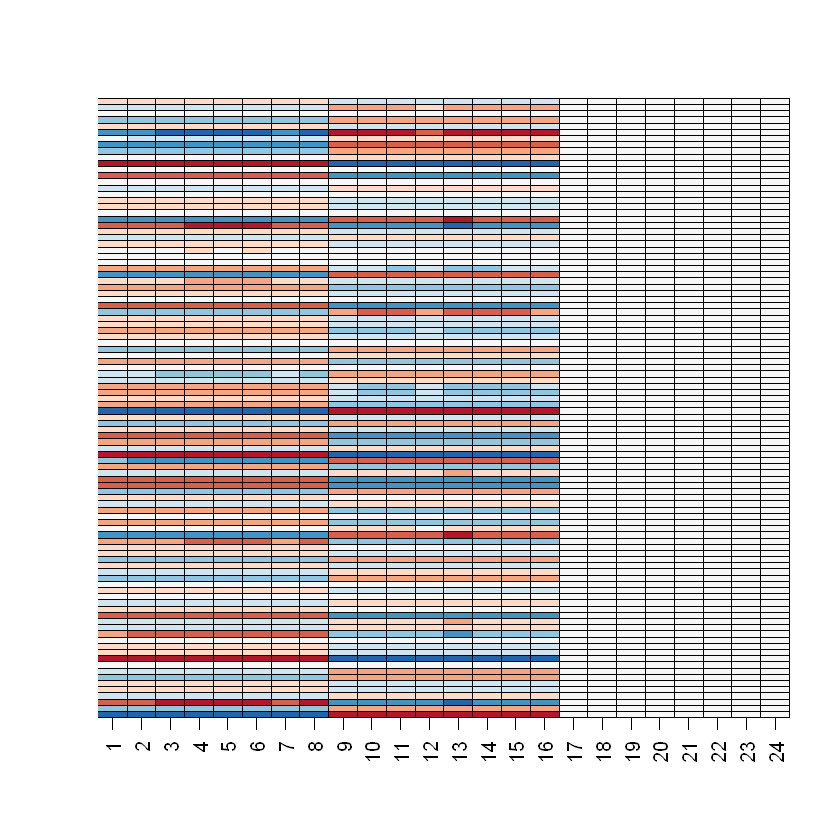

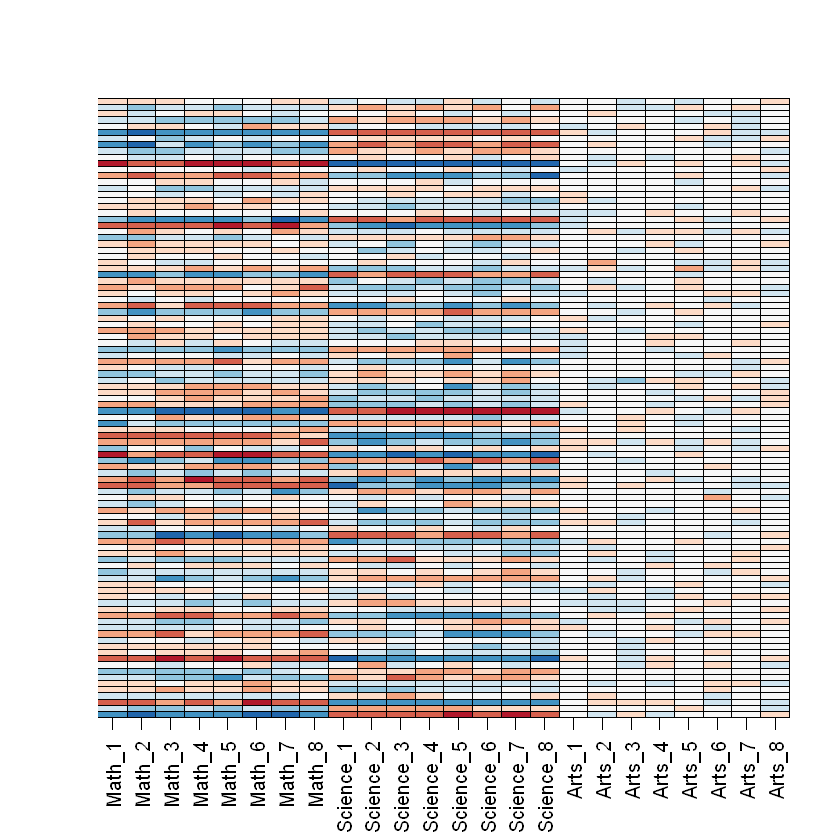

[1] 98.77922

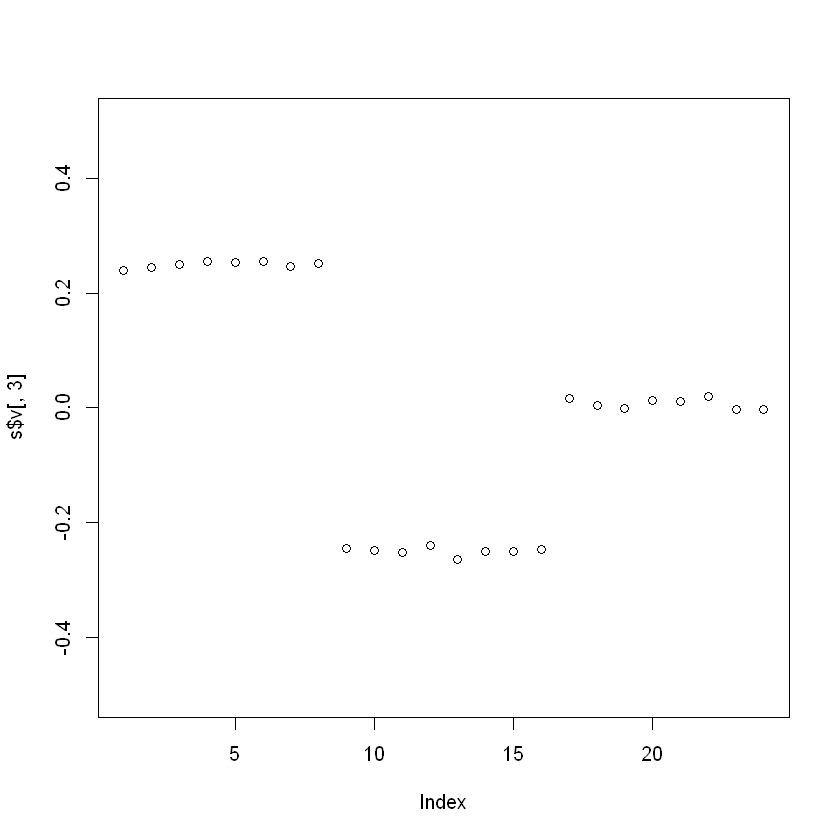

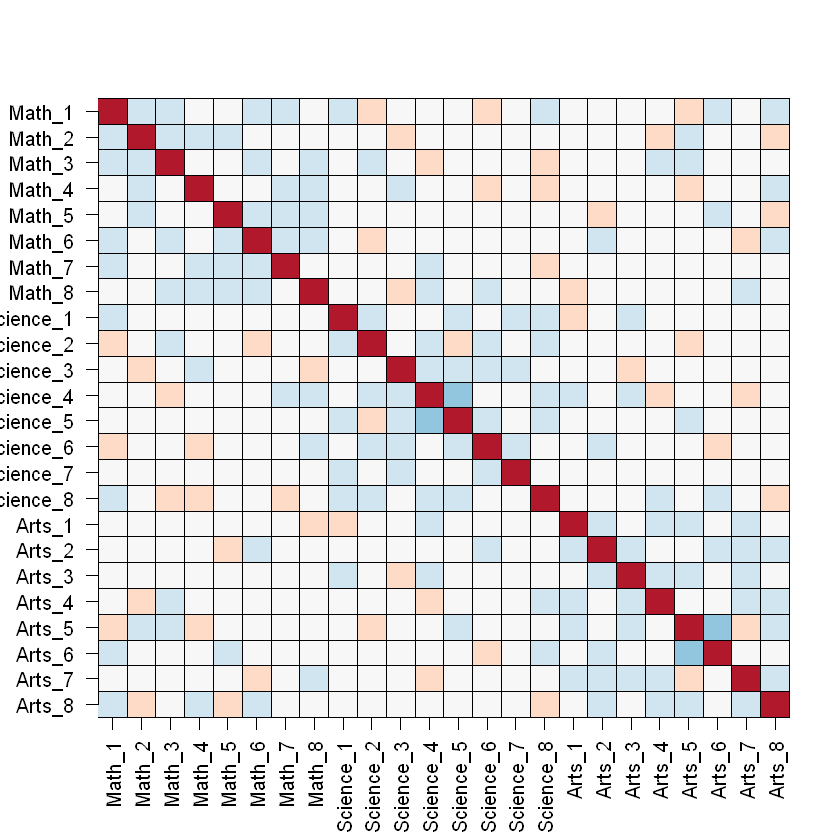

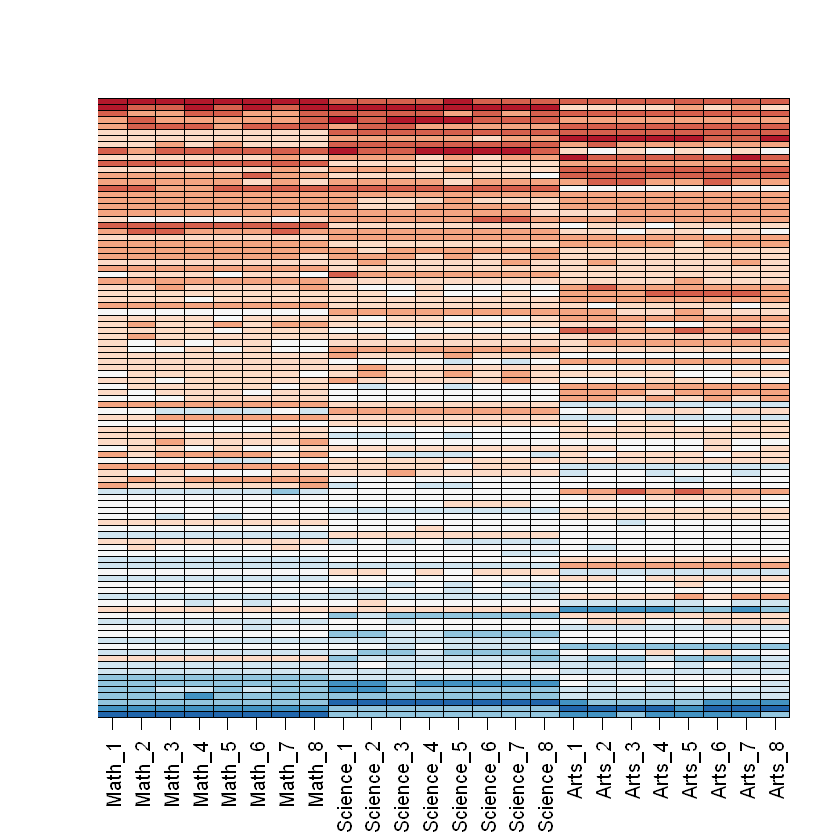

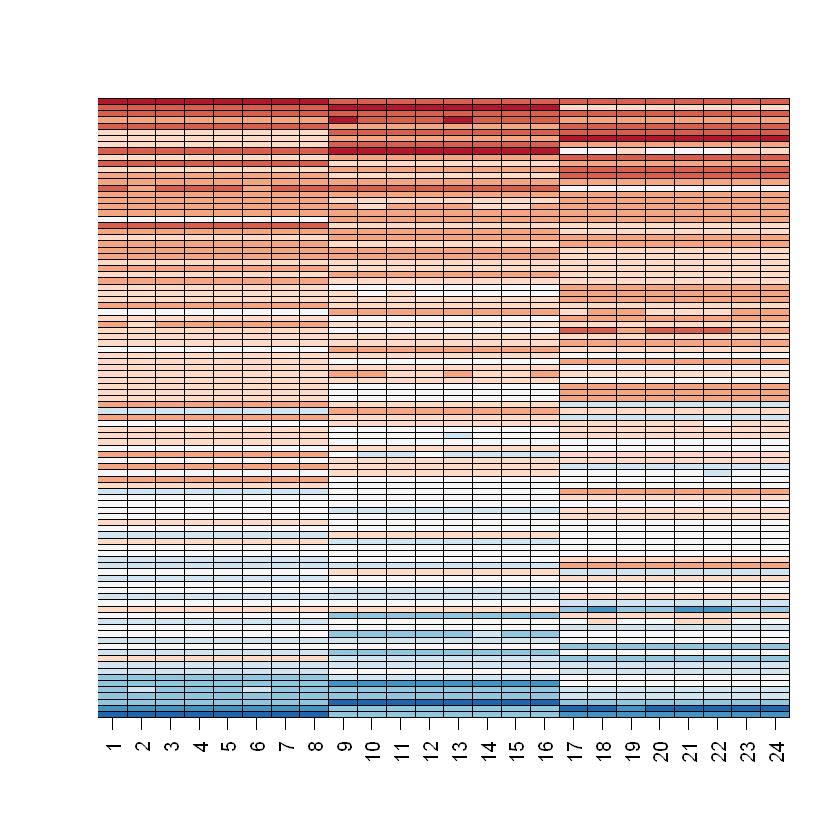

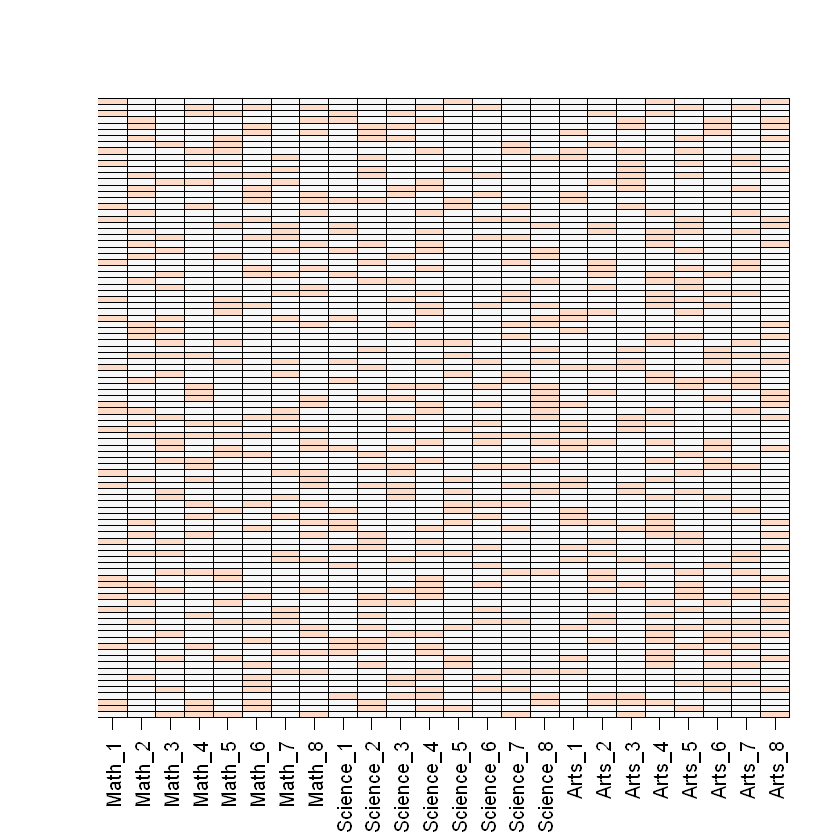

In [53]:
# Q12 - we can see the difference is between math/science versus the arts
plot(s$v[,2], ylim = c(-0.5, 0.5))

    # - adding the matrix of the 2 columns accounts for a good portion of the var
    sum(s$d[1:2]^2)/sum(s$d^2) * 100
    
    # - and we can compute new residuals
    resid <- y - with(s,sweep(u[, 1:2], 2, d[1:2], FUN="*") %*% t(v[, 1:2]))
    my_image(cor(resid), zlim = c(-1,1))
    axis(side = 2, 1:ncol(y), rev(colnames(y)), las = 2)

    # - what is left is driven by the difference between maths and science
    # - plot U3d3,3V3T, compare to our new resids
    plot(s$u[,3], ylim = c(-0.5, 0.5))
    plot(s$v[,3], ylim = c(-0.5, 0.5))
    with(s, my_image((u[, 3, drop=FALSE]*d[3]) %*% t(v[, 3, drop=FALSE])))
    my_image(resid)

# Q13 - we can see the difference is between maths and science
plot(s$v[,3], ylim = c(-0.5, 0.5))
    
    # - adding the matrix of the 3 columns accounts for a good portion of the var
    sum(s$d[1:3]^2)/sum(s$d^2) * 100
    
    # - and we can compute new residuals
    resid <- y - with(s,sweep(u[, 1:3], 2, d[1:3], FUN="*") %*% t(v[, 1:3]))
    my_image(cor(resid), zlim = c(-1,1))
    axis(side = 2, 1:ncol(y), rev(colnames(y)), las = 2)
    
    # - and with this we now longer see structure in the residuals
    # - the model is useful because we summarised 100x24 observations with 3x(100+24+1) - 375 numbers
    # - and the three components have useful interpretations
        # - overall ability
        # - difference in ability between math/science and arts
        # - difference between the three subjects
    
    # - plot an image of Y, an image of the final model, and an image of the resids
    y_hat <- with(s,sweep(u[, 1:3], 2, d[1:3], FUN="*") %*% t(v[, 1:3]))
    my_image(y, zlim = range(y))
    my_image(y_hat, zlim = range(y))
    my_image(y - y_hat, zlim = range(y))
    

In [54]:
# config
library(tidyverse)
library(dslabs)

data("tissue_gene_expression")

In [55]:
# Q1 - remove the rowMeans and compute the distance
d <- dist(tissue_gene_expression$x - rowMeans(tissue_gene_expression$x))
d

               cerebellum_1 cerebellum_2 cerebellum_3 cerebellum_4 cerebellum_5
cerebellum_2       6.980073                                                    
cerebellum_3       6.633291     7.020532                                       
cerebellum_4       7.329478     6.657902     5.317597                          
cerebellum_5       5.183018     6.312977     5.931987     6.724742             
cerebellum_6       6.312736     6.575740     5.075224     5.733852     5.862093
cerebellum_7       6.567394     7.582953     4.345565     5.692054     6.310367
cerebellum_8       5.795187     5.691057     6.247889     5.958780     4.887513
cerebellum_9       6.645861     7.874016     7.018950     6.275945     6.383420
cerebellum_10      8.825768     6.966380     9.237860     7.260257     8.173854
cerebellum_11      6.188056     5.834936     5.046478     5.119201     5.124192
cerebellum_12      6.688398     6.579192     5.240755     4.964383     5.873839
cerebellum_13      7.052292     6.080595

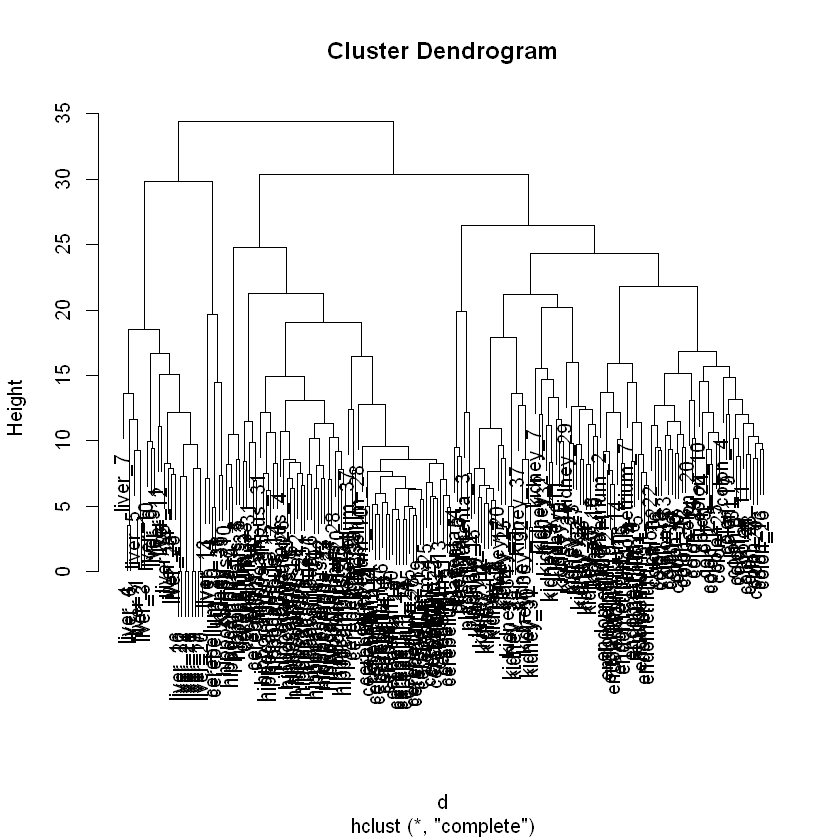

In [56]:
# Q2 - make a hierarchical clustering plot, which tissue is furthest left
hc1 <- hclust(d)
plot(hc1)


In [57]:
# Q3 - run a kmeans() around 7 and report on liver
cl <- kmeans(tissue_gene_expression$x, centers = 7)
table(cl$cluster, tissue_gene_expression$y)

   
    cerebellum colon endometrium hippocampus kidney liver placenta
  1          0    34           1           0      0     0        6
  2          0     0           0           0      0     6        0
  3          0     0          14           0     36     0        0
  4         36     0           0          29      0     0        0
  5          0     0           0           0      0    14        0
  6          0     0           0           0      0     6        0
  7          2     0           0           2      3     0        0

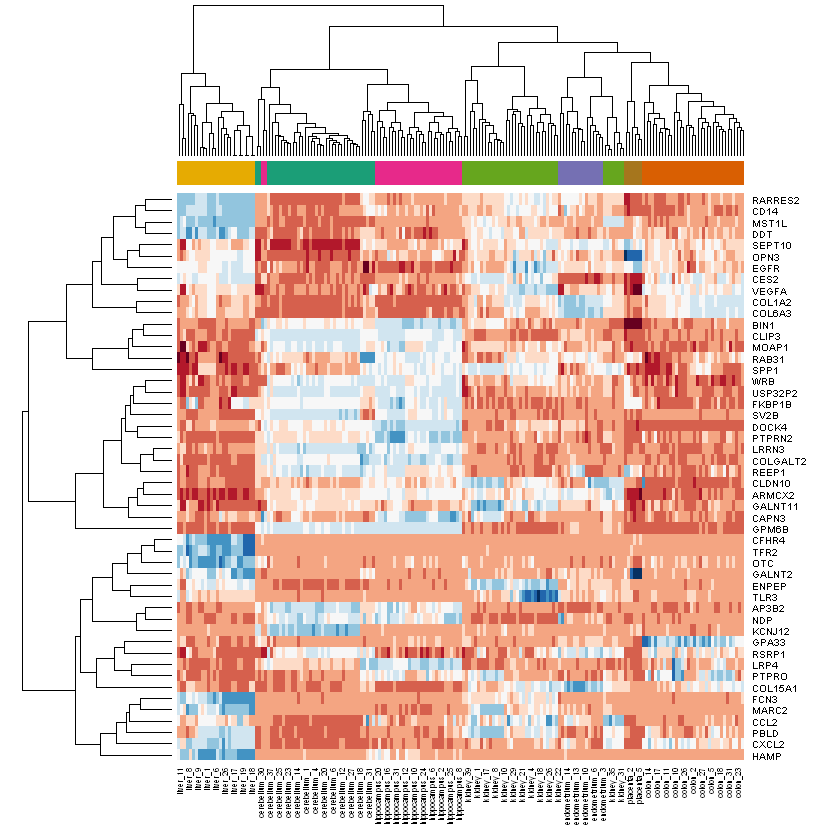

In [58]:
# Q4 - select the 50 most variable genes, create a heatmap
library(RColorBrewer)
sds <- matrixStats::colSds(tissue_gene_expression$x)
ind <- order(sds, decreasing = TRUE)[1:50]
colors <- brewer.pal(7, "Dark2")[as.numeric(tissue_gene_expression$y)]
heatmap(t(tissue_gene_expression$x[,ind]), col = brewer.pal(11, "RdBu"), scale = "row", ColSideColors = colors)

In [59]:
# config
options(digits = 3)
library(matrixStats)
library(tidyverse)
library(caret)
library(dslabs)
data(brca)


Warning message:
"package 'matrixStats' was built under R version 3.6.3"
Attaching package: 'matrixStats'

The following object is masked from 'package:dplyr':

    count



In [60]:
# q1 - data set questions
    # q1a - how many samples and predictors
    dim(brca$x)
    
    # q1b - proportion of malignant samples
    mean(ifelse(brca$y == "M", 1, 0))
    mean(brca$y == "M")

    # q1c - which column number has the highest mean
    which.max(colMeans(brca$x))
    
    # q1d - which column number has the lowest sd
    which.min(colSds(brca$x))


[1] 569  30

[1] 0.373

[1] 0.373

area_worst 
        24

[1] 20

In [61]:
# q2 - sweep twice to scale each column
x_centered <- sweep(brca$x, 2, colMeans(brca$x))
x_scaled <- sweep(x_centered, 2, colSds(brca$x), FUN='/')
    
    # q2a - what is the sd of the first column
    sd(x_scaled[,1])
    
    # q2b - what is the median of the first column
    median(x_scaled[,1])

[1] 1

[1] -0.215

In [62]:
# q3 - calculate the distance between all samples using the scaled matrix
d <- as.matrix(dist(x_scaled))

    # q3a - what is the average distance between the first sample and benign samples
    ind <- which(brca$y=="B")    
    mean((d)[1,ind])

    # q3b - what is the average distance between the first sample and malignant samples
    ind <- which(brca$y=="M")
    mean((d)[1,ind])

[1] 4.4

[1] 7.12

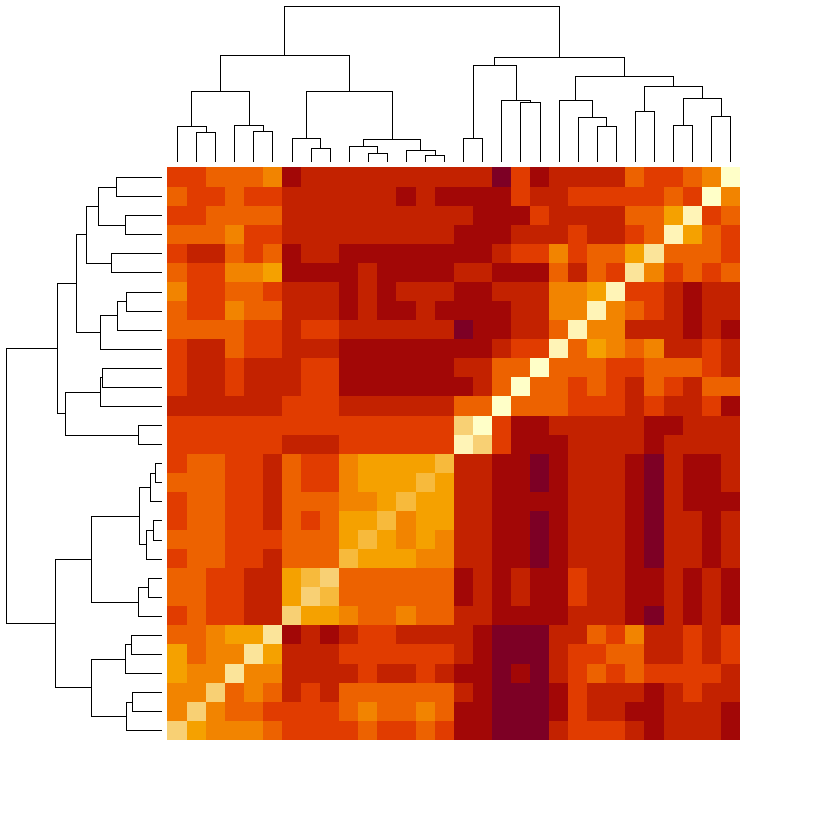

In [63]:
# q4 - make a heatmap of the relationship between features using the scaled matrix
d_features <- dist(t(x_scaled))
heatmap(as.matrix(d_features), labRow = NA, labCol = NA)


In [64]:
# q5 - perform heirarchical clustering, cut the tree into 5
    # q5a - which predictor is in its own group
    h <- hclust(d_features)
    groups <- cutree(h, k = 5)
    split(names(groups), groups)

$`1`
 [1] "radius_mean"       "perimeter_mean"    "area_mean"        
 [4] "concavity_mean"    "concave_pts_mean"  "radius_se"        
 [7] "perimeter_se"      "area_se"           "radius_worst"     
[10] "perimeter_worst"   "area_worst"        "concave_pts_worst"

$`2`
[1] "texture_mean"  "texture_worst"

$`3`
[1] "smoothness_mean"   "compactness_mean"  "symmetry_mean"    
[4] "fractal_dim_mean"  "smoothness_worst"  "compactness_worst"
[7] "concavity_worst"   "symmetry_worst"    "fractal_dim_worst"

$`4`
[1] "texture_se"    "smoothness_se" "symmetry_se"  

$`5`
[1] "compactness_se" "concavity_se"   "concave_pts_se" "fractal_dim_se"

[1] 0.443

[1] 0.443 0.632 0.726 0.792 0.847 0.888 0.910

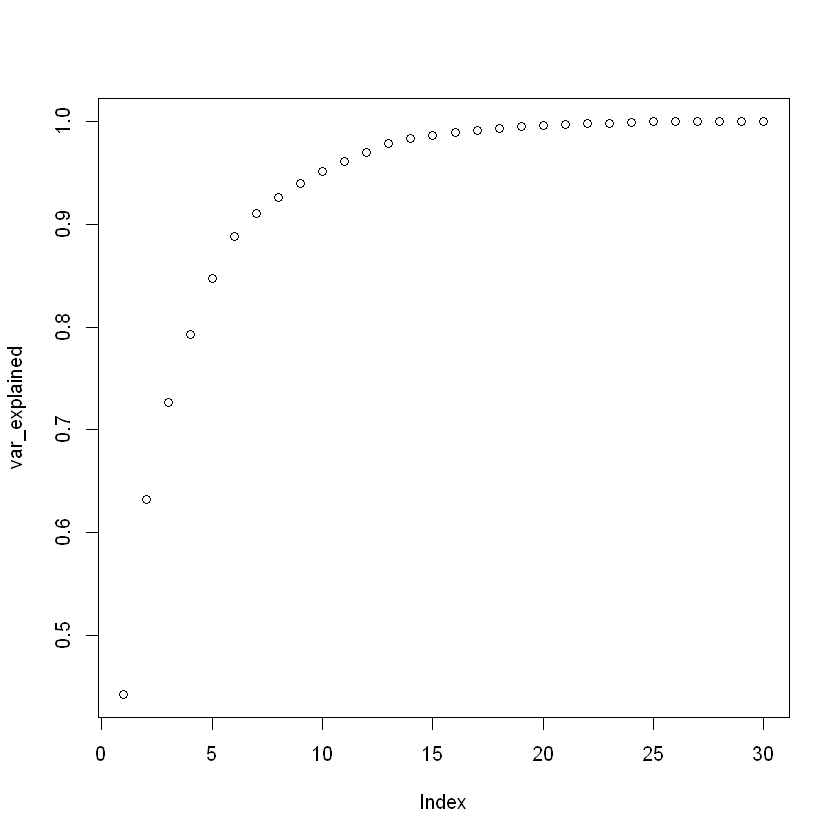

In [65]:
# q6 - perform principal component analysis
pcs <- prcomp(x_scaled)
var_explained <- cumsum(pcs$sdev^2/sum(pcs$sdev^2))
plot(var_explained)

    # q6a - what proportion of variance is explained by the first component
    var_explained[1]
    
    # q6b - how many PCs required to explain 90%
    var_explained[1:7] # first greater than 0.9 is the answer

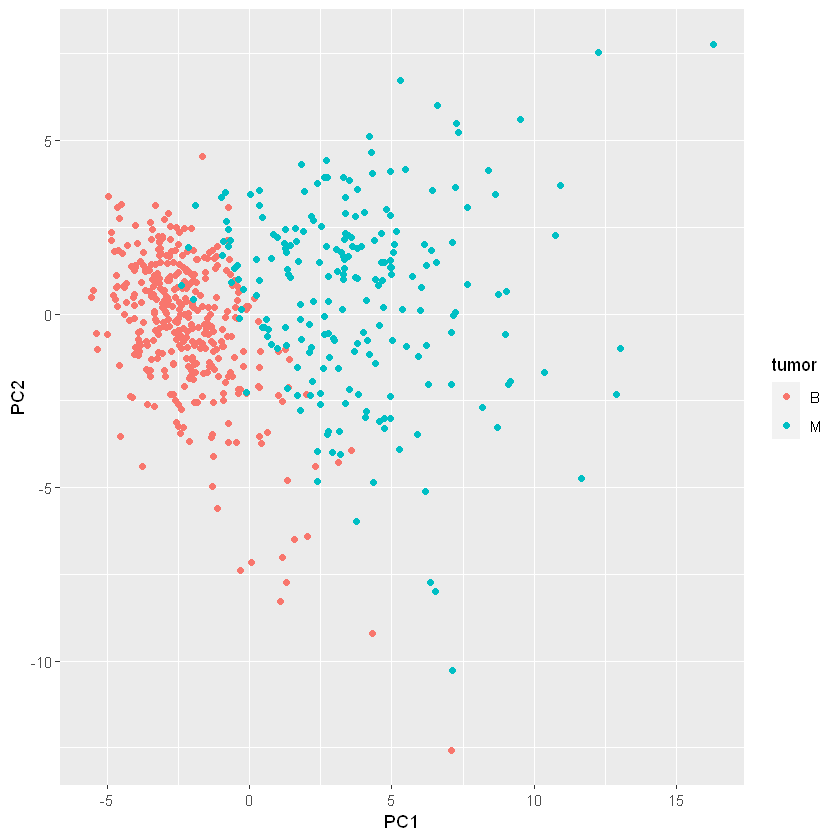

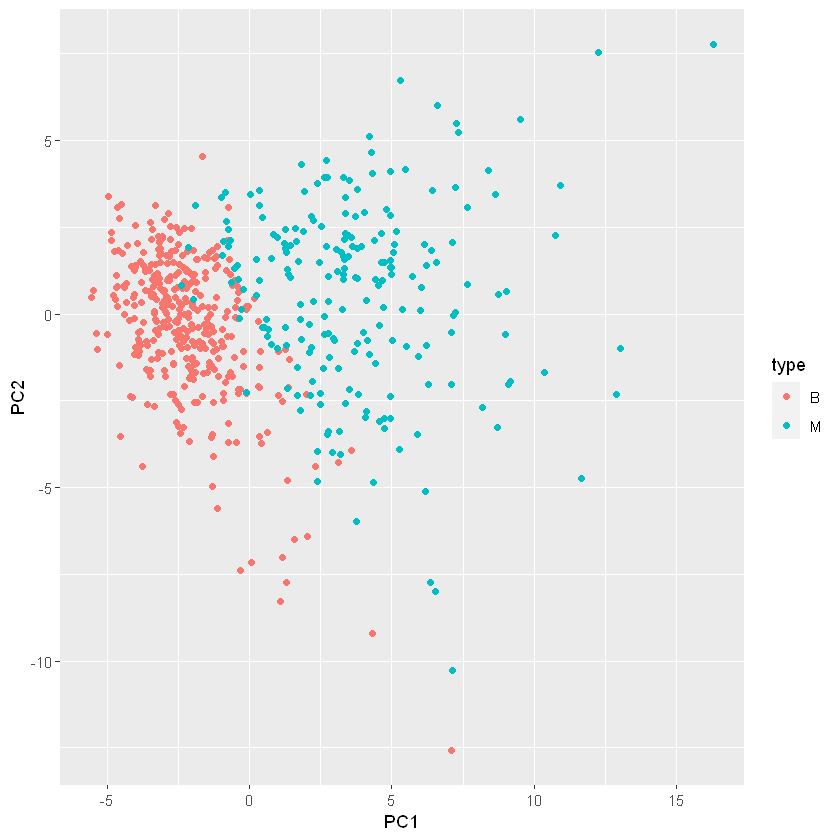

In [66]:
# q7 - plot the first two PCs, with color representing tumor
PC1 <- pcs$x[,1]
PC2 <- pcs$x[,2]
tumor <- brca$y

qplot(PC1, PC2, col=tumor)

    # EDX CORRECT ANSWER
    data.frame(pcs$x[,1:2], type = brca$y) %>%
      ggplot(aes(PC1, PC2, color = type)) +
      geom_point()


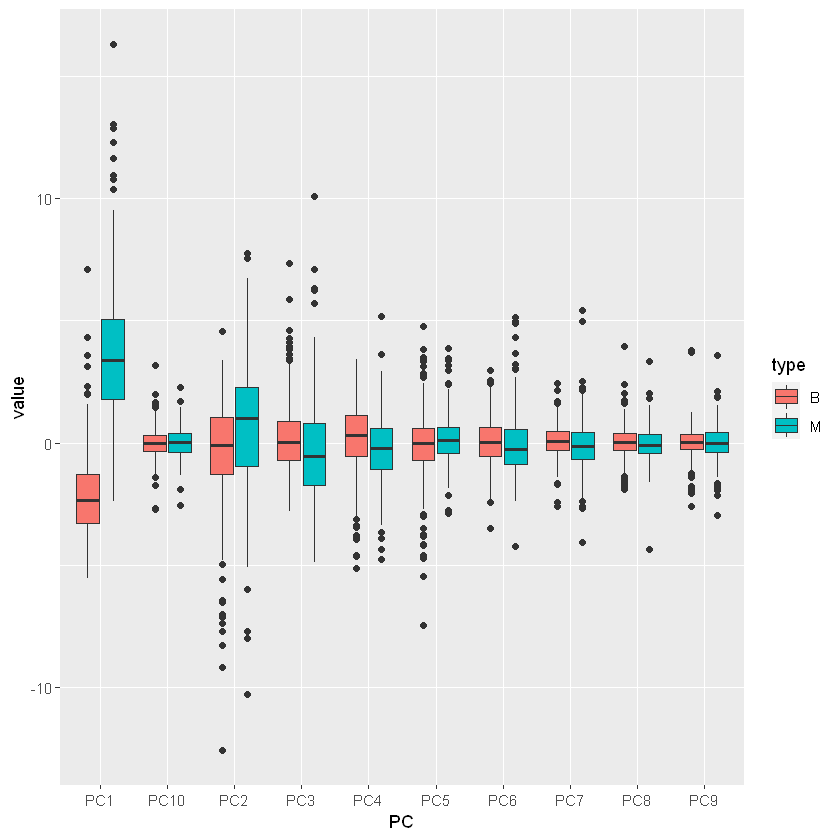

In [67]:
# q8 - make a boxplot of the first 10 pcs, grouped by tumor type
    # q8a - which PCs dont overlap IQRs for tumor type
    data.frame(pcs$x[,1:10], type = brca$y) %>%
      gather(key = "PC", value = "value", -type) %>%
      ggplot(aes(PC, value, fill = type)) +
      geom_boxplot()

In [68]:
# config
options(digits = 3)
library(matrixStats)
library(tidyverse)
library(caret)
library(dslabs)
data(brca)

# create the test and training sets
set.seed(1, sample.kind = "Rounding")
test_index <- createDataPartition(brca$y, times = 1, p = 0.2, list = FALSE)
test_x <- x_scaled[test_index,]
test_y <- brca$y[test_index]
train_x <- x_scaled[-test_index,]
train_y <- brca$y[-test_index]


Warning message in set.seed(1, sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"

In [69]:
# q9 - check the proportions of the train and test sets
    # q9a - what is the proportion of benign in the train set
    mean(train_y == "B")
    
    # q9b - what is the proportion of benign in the test set
    mean(test_y == "B")


[1] 0.628

[1] 0.626

In [73]:
# q10 - the predict_kmeans() takes two arguments, the matrix and k-means object
    predict_kmeans <- function(x, k) {
      centers <- k$centers    # extract cluster centers
      # calculate distance to cluster centers
      distances <- sapply(1:nrow(x), function(i){
        apply(centers, 1, function(y) dist(rbind(x[i,], y)))
      })
      max.col(-t(distances))  # select cluster with min distance to center
    }
    
    # q10a - perform k-means on the train set and predict the overall accuracy
    k <- kmeans(train_x, centers = 2)
    prediction12 <- as.factor(predict_kmeans(test_x, k))
    predictionBM <- as.factor(ifelse(prediction12 == 1, "B", "M"))
    confusionMatrix(test_y, predictionBM)


Confusion Matrix and Statistics

          Reference
Prediction  B  M
         B 71  1
         M  8 35
                                        
               Accuracy : 0.922         
                 95% CI : (0.857, 0.964)
    No Information Rate : 0.687         
    P-Value [Acc > NIR] : 1.28e-09      
                                        
                  Kappa : 0.827         
                                        
 Mcnemar's Test P-Value : 0.0455        
                                        
            Sensitivity : 0.899         
            Specificity : 0.972         
         Pos Pred Value : 0.986         
         Neg Pred Value : 0.814         
             Prevalence : 0.687         
         Detection Rate : 0.617         
   Detection Prevalence : 0.626         
      Balanced Accuracy : 0.935         
                                        
       'Positive' Class : B             
                                        

[1] B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B
 [38] B B B B B B B B B B B B M B B B B B B B B B B B B B B B B B B B B B B M M
 [75] M M M B M M M B B B B B M M M M M M M M M M M M B M M M M M M M B M M M M
[112] M M M M
Levels: B M

In [74]:
# Logistic Regression
train_glm <- train(train_x,train_y,method="glm")
glm_preds <- predict(train_glm,test_x)

# Logistic Regression overall accuracy
mean(glm_preds==test_y)

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted pr

[1] 0.957

In [75]:
# LDA and QDA models
train_lda <- train(train_x,train_y,method="lda")
lda_preds <- predict(train_lda,test_x)
mean(lda_preds==test_y)

[1] 0.991

In [76]:
train_qda <- train(train_x,train_y,method="qda")
qda_preds <- predict(train_qda,test_x)
mean(qda_preds==test_y)

[1] 0.957

# K-nearest neighbors
set.seed(7, sample.kind = "Rounding")
tuning <- data.frame(k=seq(3,21,2))
train_knn <- train(train_x,train_y,method="knn",tuneGrid = tuning)
train_knn$bestTune

##     k
## 10 21

knn_preds <- predict(train_knn,test_x)
mean(knn_preds == test_y)

## [1] 0.9478261

In [78]:
# Random Forest Model
set.seed(9, sample.kind = "Rounding")
tuning <- data.frame(mtry=c(3,5,7,9))
train_rf <- train(train_x,train_y, method="rf",tuneGrid = tuning, importance = TRUE)
train_rf$bestTune

Warning message in set.seed(9, sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"

mtry
3


In [79]:
rf_preds <- predict(train_rf, test_x)
mean(rf_preds == test_y)

[1] 0.974

In [80]:
# Ensemble
ensemble <- cbind(glm=glm_preds=="B",lda=lda_preds=="B",qda=qda_preds=="B",loess=loess_preds=="B",
                  rf=rf_preds=="B",knn=knn_preds=="B",kmeans=kmeans_preds=="B")

ensemble_preds <- ifelse(rowMeans(ensemble) >0.5,"B","M")
mean(ensemble_preds==test_y)

ERROR: Error in cbind(glm = glm_preds == "B", lda = lda_preds == "B", qda = qda_preds == : object 'knn_preds' not found


In [81]:
models <- c("K means", "Logistic regression", "LDA", "QDA", "Loess", "K nearest neighbors", "Random fore
st", "Ensemble")
accuracy <- c(mean(kmeans_preds == test_y),
                mean(glm_preds == test_y),
                mean(lda_preds == test_y),
                mean(qda_preds == test_y),
                mean(loess_preds == test_y),
                mean(knn_preds == test_y),
                mean(rf_preds == test_y),
                mean(ensemble_preds == test_y))
data.frame(Model = models, Accuracy = accuracy)

ERROR: Error in mean(kmeans_preds == test_y): object 'kmeans_preds' not found


Conclusion LDA Model has the highest accuracy